# Importing Pacages

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install propy3

In [ ]:
!pip install cs

In [ ]:
pip install imbalanced-learn

In [ ]:
pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from boruta import BorutaPy
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from propy import PyPro
import propy

def print_library_versions():
    libraries = {
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "scikit-learn": RandomForestClassifier.__module__.split('.')[0],
        "imblearn": SMOTE.__module__.split('.')[0],
        "boruta": BorutaPy.__module__.split('.')[0],
        "os": os.__doc__.splitlines()[0] if os.__doc__ else "No version info",
        "itertools": "Builtin module (no version)",
        "lime": "Uncomment LimeTabularExplainer to check version (if installed)",
    }

    for lib, version in libraries.items():
        try:
            if lib in ["scikit-learn", "imblearn", "boruta"]:
                print(f"{lib}: {__import__(version).__version__}")
            else:
                print(f"{lib}: {version}")
        except AttributeError:
            print(f"{lib}: Unable to retrieve version")

print_library_versions()


pandas: 2.2.2
numpy: 1.26.4
scikit-learn: 1.6.0
imblearn: 0.12.4
boruta: Unable to retrieve version
os: OS routines for NT or Posix depending on what system we're on.
itertools: Builtin module (no version)
lime: Uncomment LimeTabularExplainer to check version (if installed)


# Helper Functions

In [ ]:
#from csv to fasta
def csv_to_fasta(csv_file, fasta_file):
  data = pd.read_csv(csv_file)
  data.drop("Unnamed: 0", axis=1, inplace=True)
  for i in range(data.shape[0]):
    identifier = data["Peptide_ID"][i]
    sequence = data["Sequence"][i]
    with open(fasta_file, "a") as f:
      f.write(f">{identifier}\n{sequence}\n")

#from fasta to csv
def fasta_to_csv(fasta_file, csv_file):
    with open(fasta_file, "r") as infile, open(csv_file, "w", newline="") as outfile:
        outfile.write("Peptide_ID,Sequence\n")
        Id = None
        seq = []
        for line in infile:
            line = line.strip()
            if line.startswith(">"):
                if Id:
                    outfile.write(f"{Id},{''.join(seq)}\n")
                Id = line[1:]
                seq = []
            else:
                seq.append(line)
        if Id:
            outfile.write(f"{Id},{''.join(seq)}\n")

In [ ]:
def merge_on_common_column(dataframes, merge_column):
  merged_df = dataframes[0]
  for df in dataframes[1:]:
          merged_df = pd.merge(merged_df, df, on=merge_column)
  return merged_df

In [ ]:
def drop_outliers(df, columns):
    for col in columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [ ]:
def plot_distributions(df, file_name):
    numeric_columns = df.select_dtypes(include='number').columns

    for col in numeric_columns:
        plt.figure(figsize=(8, 4))
        df[col].plot(kind='hist', bins=30, alpha=0.5, label='Histogram', color='blue', density=True)
        df[col].plot(kind='kde', label='Density', color='red')
        plt.title(f"Distribution of {col} - {file_name}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.show()


In [ ]:
def minmax_normalize(df):
    numeric_columns = df.select_dtypes(include='number').columns
    scaler = MinMaxScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

# Initialization of the project(Data preparation & initial preprocessing)



---



---

This step should be done manually due to different colnames of datasets

In [4]:
ADA = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/ADAPTABLE/ADAPTABLE_Sequence_Data.csv")
ADA["Activity"] = "AMP"
ADA = ADA.set_axis(['Peptide_ID', 'Sequence', "Activity"], axis=1)
ADA.to_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/ADA.csv")

In [ ]:
APD3 = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/APD3/APD3_Sequence_Data.csv")
APD3["Activity"] = "AMP"
APD3 = APD3.set_axis(['Peptide_ID', 'Sequence', "Activity"], axis=1)
APD3.to_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/APD3.csv")
APD3.shape

(5036, 3)

In [ ]:
DRAMP = pd.read_excel("/content/drive/MyDrive/AMPs/Project Data/DRAMP/general_amps.xlsx")
DRAMP["Activity"] = "AMP"
for i in DRAMP.columns:
    if i not in ["DRAMP_ID", "Sequence", "Activity"]:
        DRAMP.drop(i, axis=1, inplace=True)
DRAMP = DRAMP.set_axis(['Peptide_ID', 'Sequence', "Activity"], axis=1)
DRAMP.to_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/DRAMP.csv")
DRAMP.shape

(11612, 3)

In [ ]:
ADAM = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/ADAM/ADAM_Sequence_Data.csv")
ADAM["Activity"] = "AMP"
ADAM = ADAM.set_axis(['Peptide_ID', 'Sequence', "Activity"], axis=1)
ADAM.to_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/ADAM.csv")
ADAM.shape

(2951, 3)

In [ ]:
#CAMP
CAMP = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/CAMP/CAMP_Sequence_Data.csv")
CAMP["Activity"] = "AMP"
CAMP = CAMP.set_axis(['Peptide_ID', 'Sequence', "Activity"], axis=1)
CAMP.to_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/CAMP.csv")
CAMP.shape

(2766, 3)

In [ ]:
# dbAMP
dbAMP = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/dbAMP/dbAMP_Sequence_Data.csv")
dbAMP["Activity"] = "AMP"
dbAMP = dbAMP.set_axis(['Peptide_ID', 'Sequence', "Activity"], axis=1)
dbAMP.to_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/dbAMP.csv")
dbAMP.shape

(6567, 3)

**Read Non-AMPs and Handle**

In [ ]:
fasta_to_csv("/content/drive/MyDrive/AMPs/Project Data/Non-AMPs/train_nonAMP_9777.fasta",
             "/content/drive/MyDrive/AMPs/Project Data/Non-AMPs/nonAMPs.csv")

In [ ]:
nonAMP = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Non-AMPs/nonAMPs.csv")
nonAMP["Activity"] = "nonAMP"
nonAMP = nonAMP.set_axis(['Peptide_ID', 'Sequence', "Activity"], axis=1)
nonAMP.to_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/nonAMPs.csv")

Dim of Datasets

In [ ]:
print("APD3: ",APD3.shape)
print("DRAMP:", DRAMP.shape)
print("ADAM: ",ADAM.shape)
print("CAMP: ",CAMP.shape)
print("dbAMP: ",dbAMP.shape)
print("nonAMP: ",nonAMP.shape)

c = 0
for i in [APD3, DRAMP, ADAM, CAMP, dbAMP]:
  c += i.shape[0]
print("Total: ", c)

ADA:  (26456, 3)
APD3:  (5036, 3)
DRAMP: (11612, 3)
ADAM:  (2951, 3)
CAMP:  (2766, 3)
dbAMP:  (6567, 3)
nonAMP:  (9777, 3)
Total:  28932


##Read Handled files & Merging

In [ ]:
Data_Dir = "/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING"

csv_files = [file for file in os.listdir(Data_Dir) if file.endswith('.csv')]
dataframes = []

for file in csv_files:
    file_path = os.path.join(Data_Dir, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

AMPs = pd.concat(dataframes, axis=0, ignore_index=True)
AMPs.drop("Unnamed: 0", axis=1, inplace=True)
AMPs.to_csv("/content/drive/MyDrive/AMPs/Project Data/Merged_data/AMPs.csv", index=False)

(28932, 3)

## Initial Preprocessing

Length and Unknown AA filter


**FOR AMPs**

In [ ]:
data_for_length = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Merged_data/AMPs.csv")
data_for_length = pd.DataFrame(data_for_length)
data = data_for_length.Sequence.str.upper()
invalid_conditions = (data.str.len() < 10) | (data.str.len() > 100) | (data.str.contains("[UOBZJX ]"))
data_for_length = data_for_length[~invalid_conditions]

data_for_length.to_csv("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA-Filtered_AMPs.csv")

(28932, 3)
(24666, 3)


# New Section

**FOR NON-AMPs**

In [ ]:
dataa_for_length = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Updated_AFTER_HANDELING/nonAMPs.csv")
dataa_for_length = pd.DataFrame(dataa_for_length)
dataa = dataa_for_length.Sequence.str.upper()
invalidd_conditions = (dataa.str.len() < 10) | (dataa.str.len() > 100) | (dataa.str.contains("[UOBZJX ]"))
dataa_for_length = dataa_for_length[~invalidd_conditions]

dataa_for_length.to_csv("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA-Filtered_NON-AMPs.csv")

(9777, 4)
(1883, 4)


**Check duplicates**

In [ ]:
df1 = data_for_length['Sequence']
duplicates1 = df1[df1.duplicated()]
print("AMPs duplicates--> ", duplicates1)

AMPs duplicates-->  1050                        GLPTCGETCFGGTCNTPGCTCDPWPICTRD
3727              ATCDLLSPFKVGHAACALHCIALGRRGGWCDGRAVCNCRR
3754                   RRIRPRPPRLPRPRPRPLPFPRPGPRPIPRPLPFP
3877                                         GLLSLLSLLGKAL
4407                             WGAQRLTKELLEYLRKFGKIARKAW
                               ...                        
28827              GGGSLTQINTTLLDLTYEMLSLQQVVKALNESYIDLKEL
28858                                        VKKFPWWWPFLKK
28879    DDTRGGFHGGGFGRPGRPGRPGSGILDTIVDGLTGSIHGGQGGIHG...
28883                                       KANEGLTWNSLKDK
28884                                         TNGESTADWAKN
Name: Sequence, Length: 10959, dtype: object


In [ ]:
df2 = dataa_for_length['Sequence']
duplicates2 = df2[df2.duplicated()]
print("Non-AMPs duplicates--> ", duplicates2)

Non-AMPs duplicates-->  Series([], Name: Sequence, dtype: object)


CSV to FASTA for cd-hit

AMPs

In [ ]:
csv_to_fasta("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA-Filtered_AMPs.csv",
             "/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA-Filtered_AMPss1.fasta")


Non-AMPs

In [ ]:
csv_to_fasta("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA-Filtered_NON-AMPs.csv",
             "/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA-Filtered_NON-AMPs.fasta")


Identity filter(CD-Hit program-Out of notebook)


---



FASTA to CSV for further steps

**FOR AMPs**

In [ ]:
fasta_to_csv("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/cd_hit_final_filtered_AMPs (3).fasta",
             "/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA&SIMILARITY-Filtered_AMPs.csv")

In [ ]:
final_data_AMPs = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA&SIMILARITY-Filtered_AMPs.csv", on_bad_lines="skip")
final_data_AMPs = pd.DataFrame(final_data_AMPs)
final_data_AMPs["Activity"] = "AMP"
final_data_AMPs.shape

Peptide_ID                                           Sequence Activity
0         AP00001                  GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV      AMP
1         AP00003  DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...      AMP
2         AP00004  NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC      AMP
3         AP00005                 VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK      AMP
4         AP00006                                 GNNRPVYIPQPRPPHPRI      AMP
...           ...                                                ...      ...
7513  dbAMP_34173                      IRIAINGFGRIGRLVLRLALQRKDIEVVA      AMP
7514  dbAMP_34392                                        WRGITKVVKKV      AMP
7515  dbAMP_34394                                     WGIRRILKYGKRSK      AMP
7516  dbAMP_34445  GTPGPQGIAGQRGVVAEAAAKEAAAKEAAAKASGSLSTFFRLFNRS...      AMP
7517  dbAMP_34446                                  CGGLLLFLLKKRKKRKY      AMP

[7518 rows x 3 columns]

**FOR NON-AMPs**

In [ ]:
fasta_to_csv("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/cd_hit_final_filtered_Non_AMPs (3).fasta",
             "/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA&SIMILARITY-Filtered_NON-AMPs.csv")

In [ ]:
final_data_NonAMPs = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Preprocessed_data/Length&UnknownAA&SIMILARITY-Filtered_NON-AMPs.csv", on_bad_lines="skip")
final_data_NonAMPs = pd.DataFrame(final_data_NonAMPs)
final_data_NonAMPs["Activity"] = "nonAMP"
final_data_NonAMPs.shape

(1770, 3)

## **MERGING BOTH CLASSES(Generate the dataframe)**

In [ ]:
data_frames = []
data_frames.append(final_data_AMPs)
data_frames.append(final_data_NonAMPs)

Final_data = pd.concat(data_frames, axis=0, ignore_index=True)
print(Final_data.shape)


Final_data.to_csv("/content/drive/MyDrive/AMPs/Project Data/Final_data/Final_data.csv")

(9288, 3)


# Feature Extraction

Please note the dataframe has all data (AMPs and Non-AMPs) merged (not ranomized) and please if u will read the file path drop the column ("unnamed: 0")

In [ ]:
Final_data = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Final_data/Final_data.csv")

In [ ]:
Final_data.isna().sum()

Peptide_ID    0
Sequence      0
Activity      0
dtype: int64

## AAC

In [ ]:
data = {}
for seq, label in zip(Final_data['Sequence'], Final_data['Activity']):
  data[seq] = propy.AAComposition.CalculateAADipeptideComposition(seq)
  data[seq]['Activity'] = label
AAC_df = pd.DataFrame.from_dict(data, orient='index').reset_index()
AAC_df.rename(columns={'index': 'Sequence'}, inplace=True)
AAC_df = pd.concat([AAC_df.iloc[:,:421], AAC_df.iloc[:,-1]], axis=1)

KeyboardInterrupt: 

## Autocorrelation

In [ ]:
data = {}
for seq, label in zip(Final_data['Sequence'], Final_data['Activity']):
  data[seq] = propy.Autocorrelation.CalculateAutoTotal(seq)
  data[seq]['Activity'] = label
Autocorr_df = pd.DataFrame.from_dict(data, orient='index').reset_index()
Autocorr_df.rename(columns={'index': 'Sequence'}, inplace=True)

## CTD

In [ ]:
data = {}
for seq, label in zip(Final_data['Sequence'], Final_data['Activity']):
  data[seq] = propy.CTD.CalculateCTD(seq)
  data[seq]['Activity'] = label
ctd_df = pd.DataFrame.from_dict(data, orient='index').reset_index()
ctd_df.rename(columns={'index': 'Sequence'}, inplace=True)

## PseAAC

In [ ]:
data = {}
for seq, label in zip(Final_data['Sequence'], Final_data['Activity']):
  data[seq] = propy.PseudoAAC.GetAPseudoAAC(seq, lamda= 9)
  data[seq]['Activity'] = label
pseaac_df = pd.DataFrame.from_dict(data, orient='index').reset_index()
pseaac_df.rename(columns={'index': 'Sequence'}, inplace=True)

## all posible combinations

In [ ]:
features = {"ctd": ctd_df, "aac": AAC_df, 'autocorr': Autocorr_df, 'pseaac': pseaac_df}

combs = []
for r in range(1, len(features) + 1):
    combs.extend(combinations(features.keys(), r))

final_combs = list(set(combs))

In [ ]:
final_combs

[('pseaac',),
 ('aac', 'pseaac'),
 ('ctd', 'pseaac'),
 ('aac', 'autocorr'),
 ('autocorr', 'pseaac'),
 ('ctd', 'aac', 'autocorr', 'pseaac'),
 ('aac', 'autocorr', 'pseaac'),
 ('ctd', 'aac', 'autocorr'),
 ('ctd',),
 ('ctd', 'autocorr', 'pseaac'),
 ('ctd', 'aac', 'pseaac'),
 ('autocorr',),
 ('aac',),
 ('ctd', 'autocorr'),
 ('ctd', 'aac')]

In [ ]:
merged_combinations = {}

for comb in final_combs:

    dfs_to_merge = [features[key] for key in comb]

    merged_df = merge_on_common_column(dfs_to_merge, 'Sequence')
    comb_name = "_".join(sorted(comb))
    file_name = f"{comb_name}.csv"

    # Save to CSV
    output_path = os.path.join('/content/drive/MyDrive/ML project/Comb', file_name)
    merged_df.to_csv(output_path, index=False)
    print(f"Saved: {file_name}")
    print(merged_df.shape)

Saved: pseaac.csv
(9228, 40)
Saved: aac_pseaac.csv
(9228, 460)
Saved: ctd_pseaac.csv
(9228, 187)
Saved: aac_autocorr.csv
(9228, 1142)
Saved: autocorr_pseaac.csv
(9228, 760)
Saved: aac_autocorr_ctd_pseaac.csv
(9228, 1327)
Saved: aac_autocorr_pseaac.csv
(9228, 1180)
Saved: aac_autocorr_ctd.csv
(9228, 1289)
Saved: ctd.csv
(9228, 149)
Saved: autocorr_ctd_pseaac.csv
(9228, 907)
Saved: aac_ctd_pseaac.csv
(9228, 607)
Saved: autocorr.csv
(9228, 722)
Saved: aac.csv
(9228, 422)
Saved: autocorr_ctd.csv
(9228, 869)
Saved: aac_ctd.csv
(9228, 569)


# **Preprocessing(continued)**

Reading Files


In [8]:
input_dir = "/content/drive/MyDrive/AMPs/Project Data/All combinations"
output_dir = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"

Descriptive stats

In [ ]:
for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(input_dir, file)
        df = pd.read_csv(file_path)
        if "Unnamed: 0" in df.columns:
            df = df.drop("Unnamed: 0", axis=1)
        print("File: ",  file)

        #describe
        print("Descriptive:")
        print(df.describe())

        #NAs
        print("Missing Values:")
        print(df.isna().sum())
        print()


File:  pseaac.csv
Descriptive:
            APAAC1        APAAC2       APAAC3       APAAC4       APAAC5  \
count  9228.000000   9228.000000  9228.000000  9228.000000  9228.000000   
mean      7.185471      1.520625     2.786903     2.935167     4.251578   
std     100.642377    361.867787    81.550190    73.820505    50.914497   
min   -4706.000000 -28070.000000 -4545.500000 -1709.333000 -3508.667000   
25%       0.000000      0.000000     0.000000     0.000000     0.000000   
50%       4.184000      3.597000     1.511500     0.501000     0.000000   
75%       9.587750      8.135250     4.602000     4.056000     6.086250   
max    3030.000000   5000.000000  3030.000000  6060.667000  2500.000000   

            APAAC6       APAAC7        APAAC8       APAAC9      APAAC10  ...  \
count  9228.000000  9228.000000   9228.000000  9228.000000  9228.000000  ...   
mean      2.713139     3.154972      7.960001     0.651830     5.321686  ...   
std     118.251522    64.460835    148.194049    80.3

Outliers Check

File: pseaac.csv


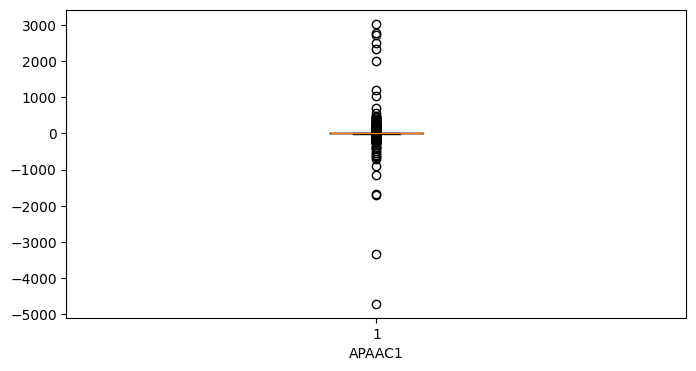

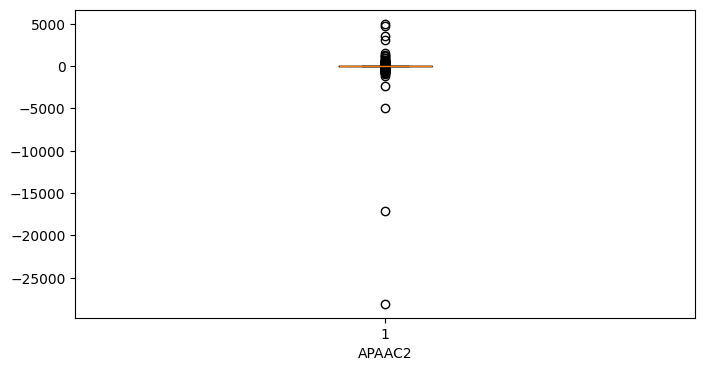

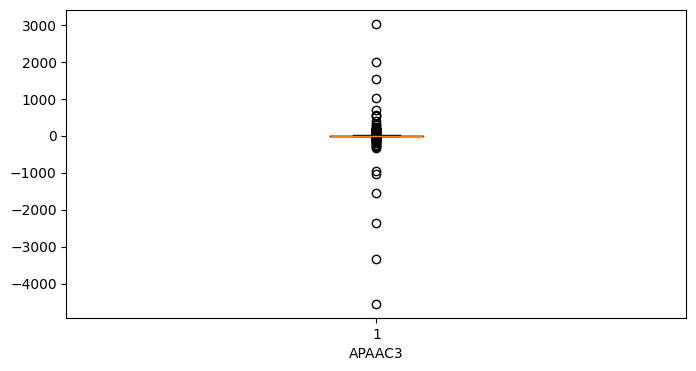

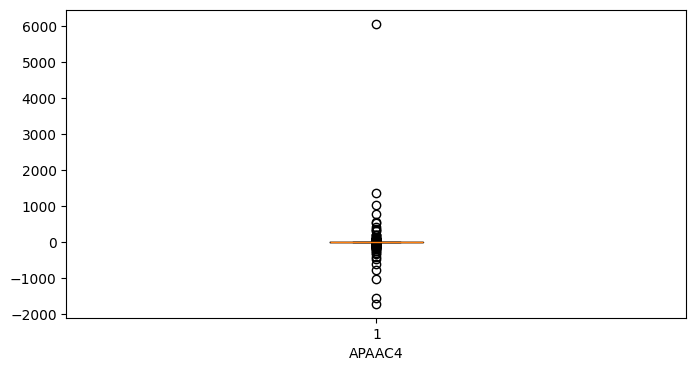

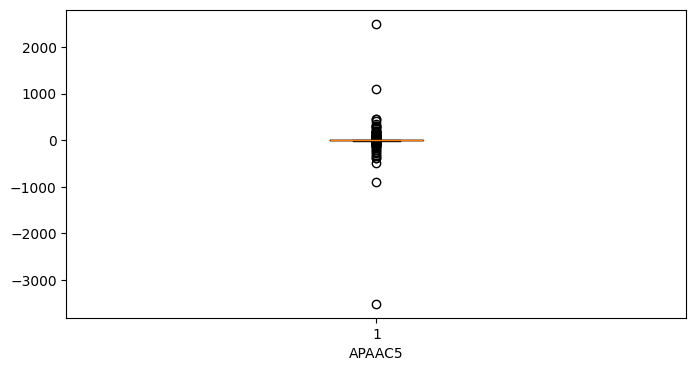

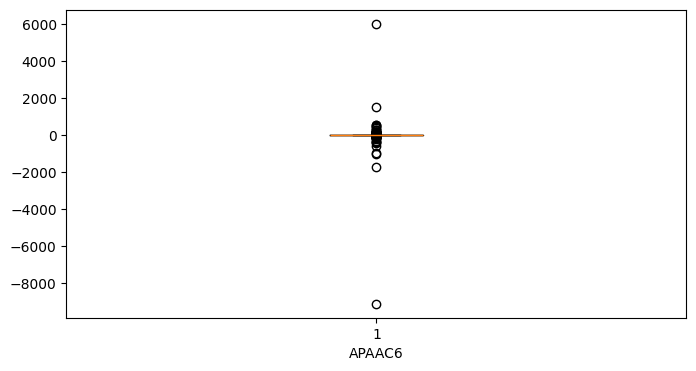

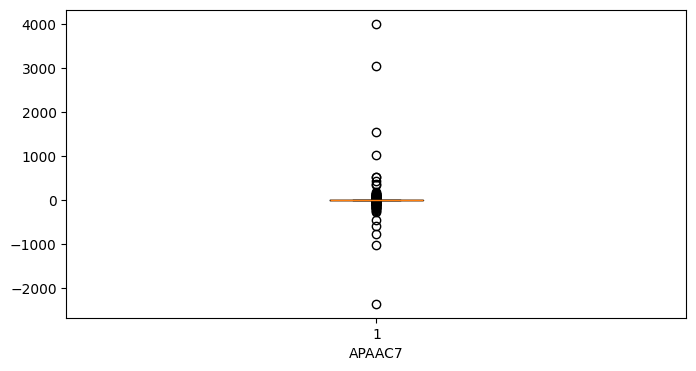

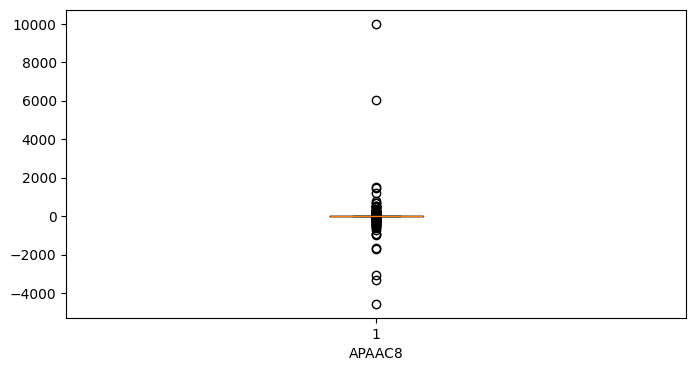

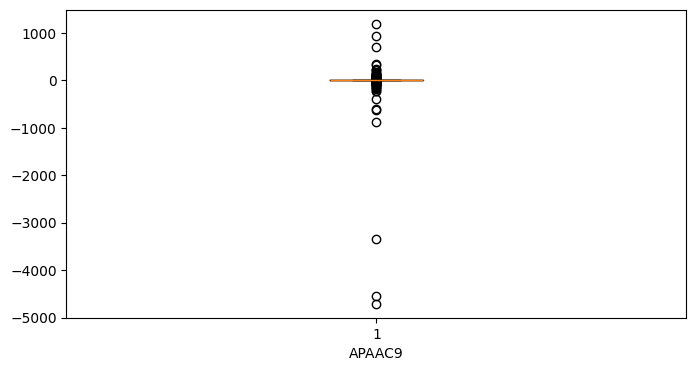

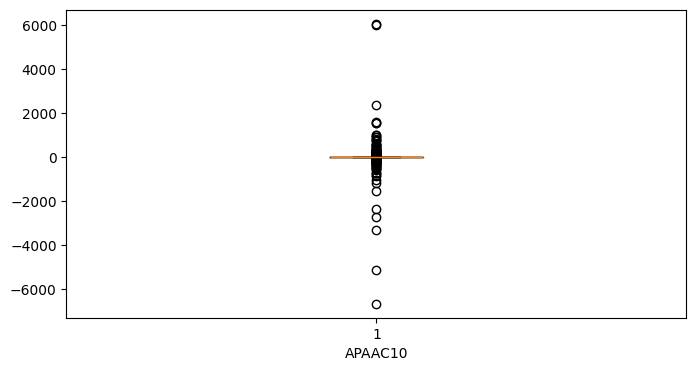

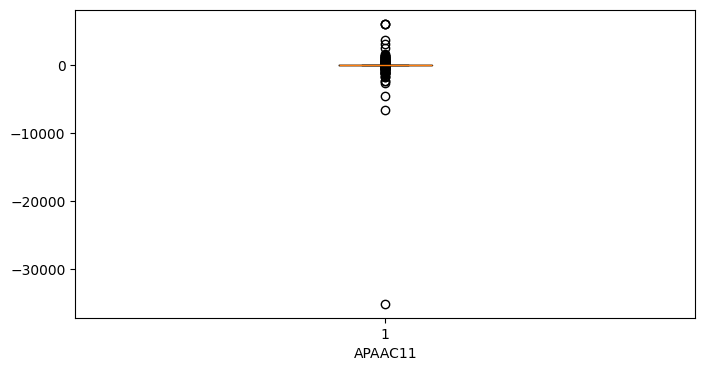

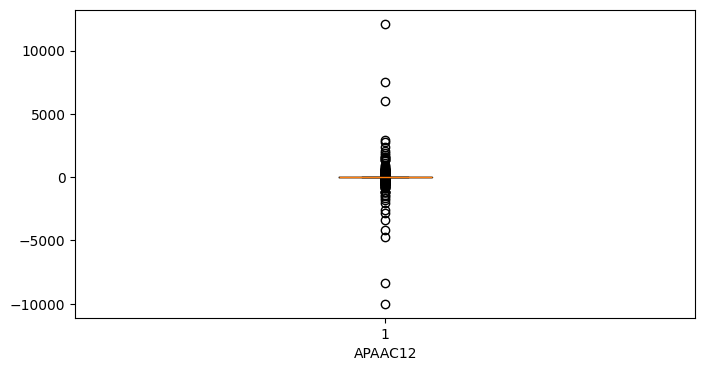

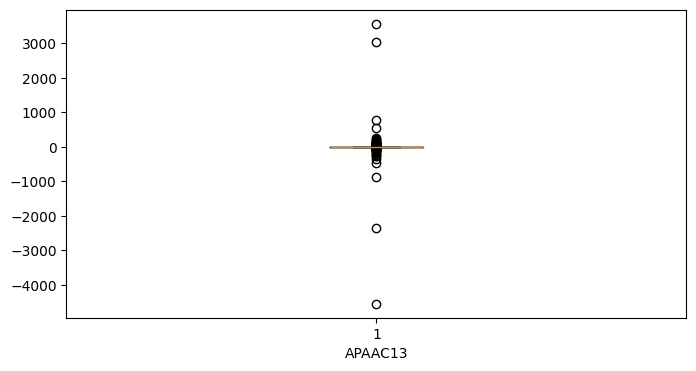

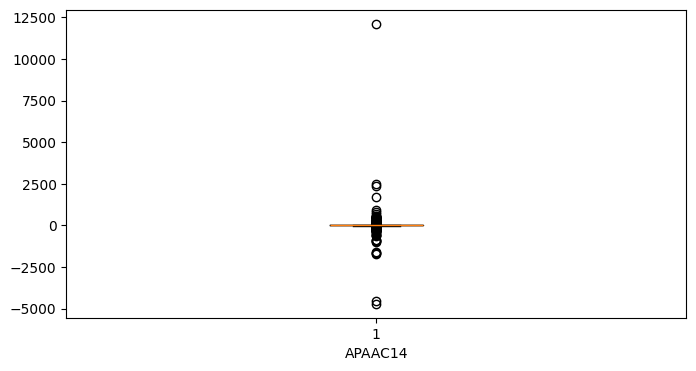

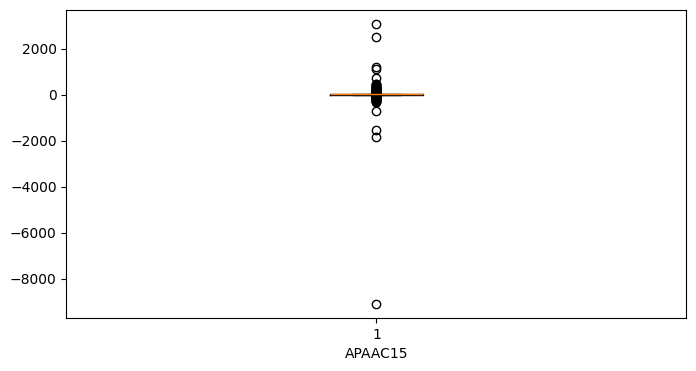

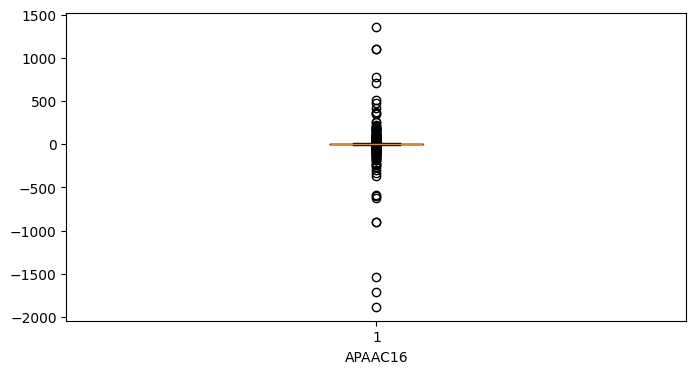

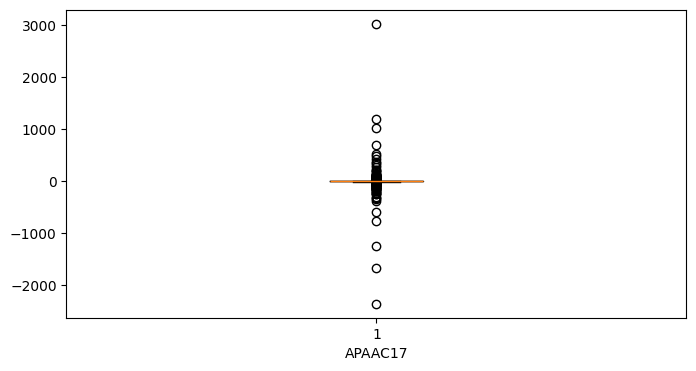

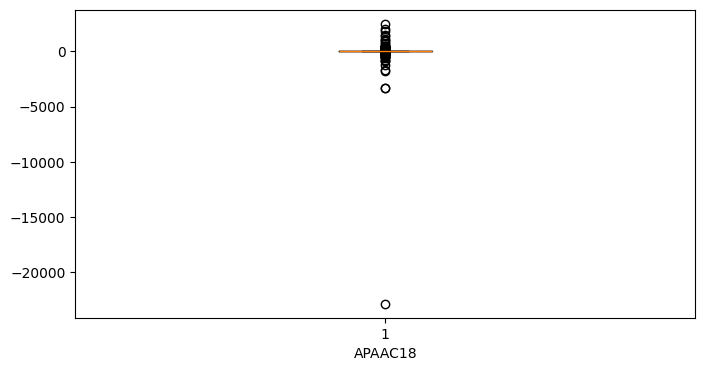

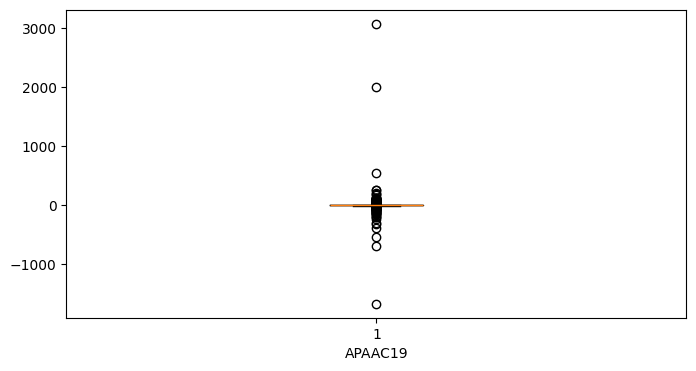

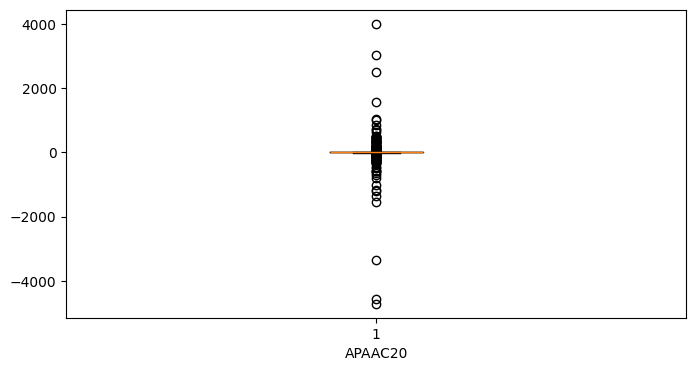

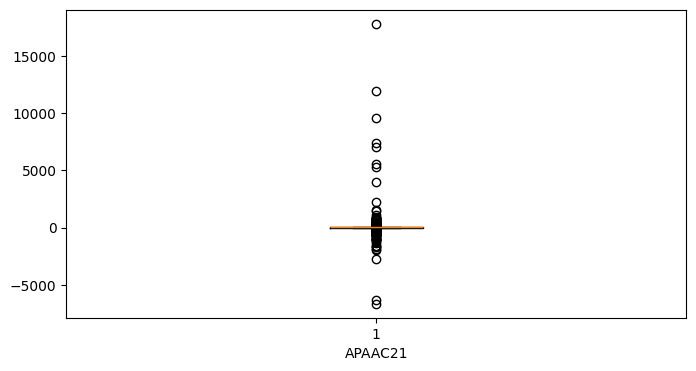

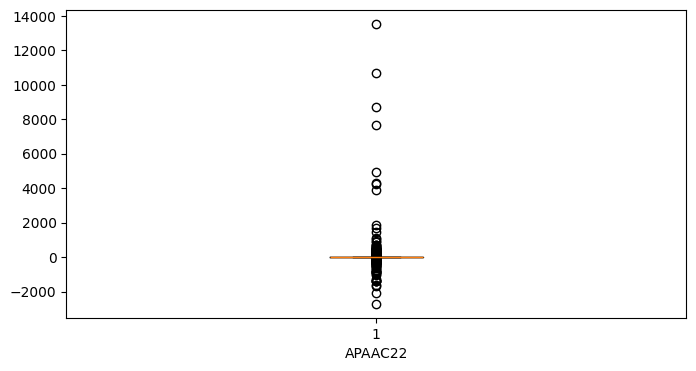

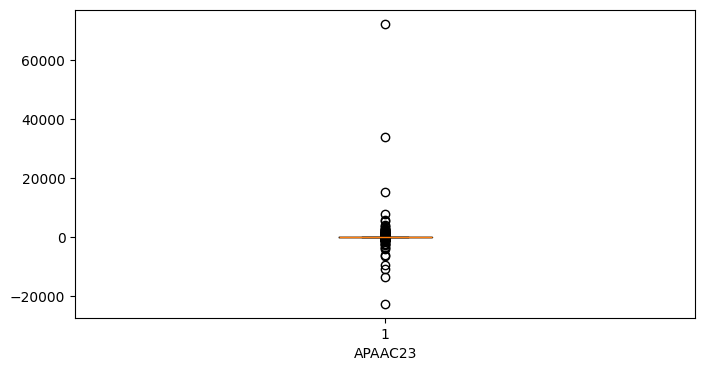

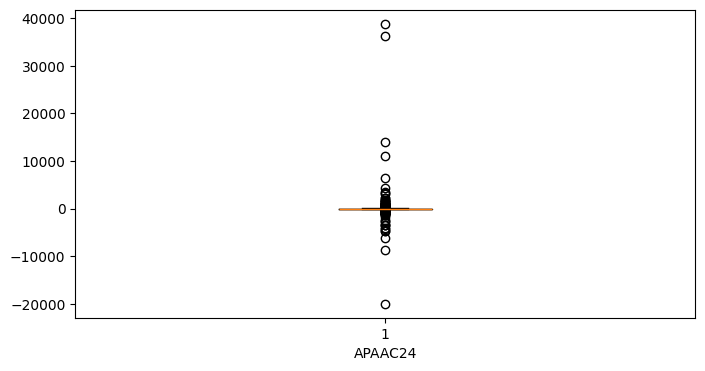

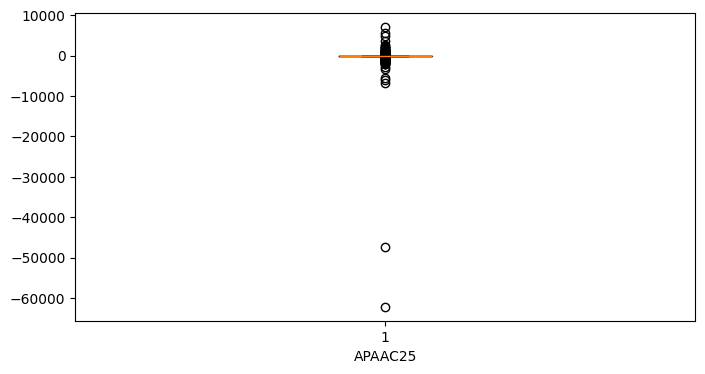

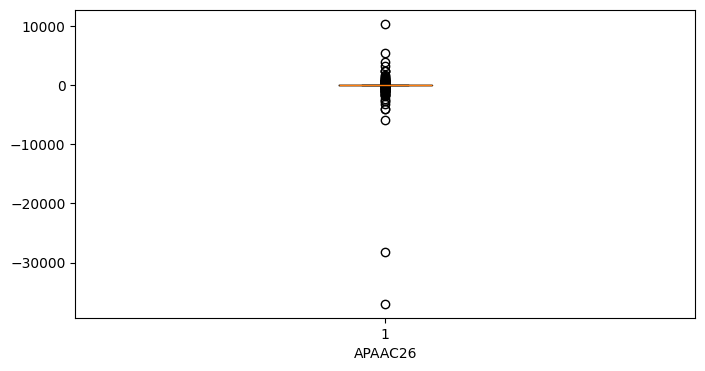

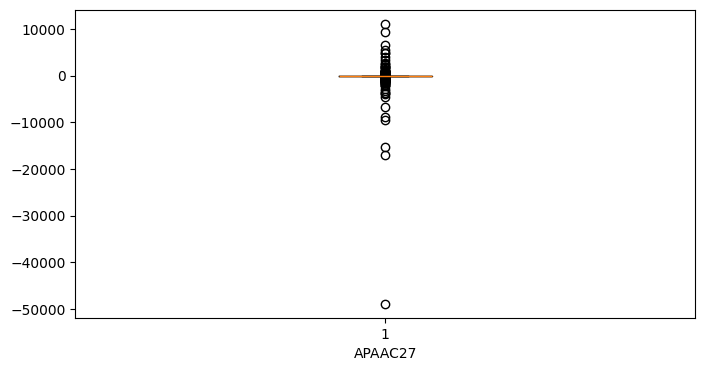

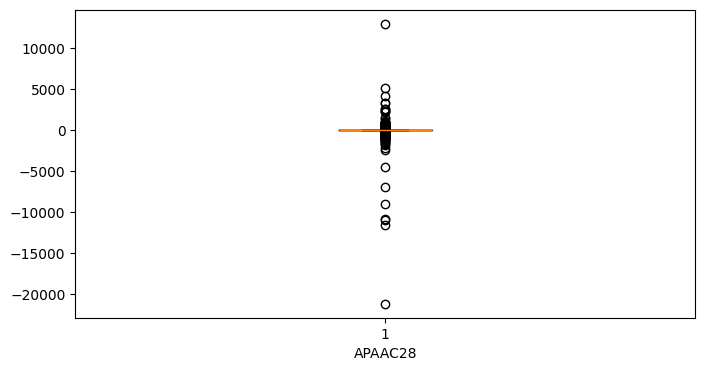

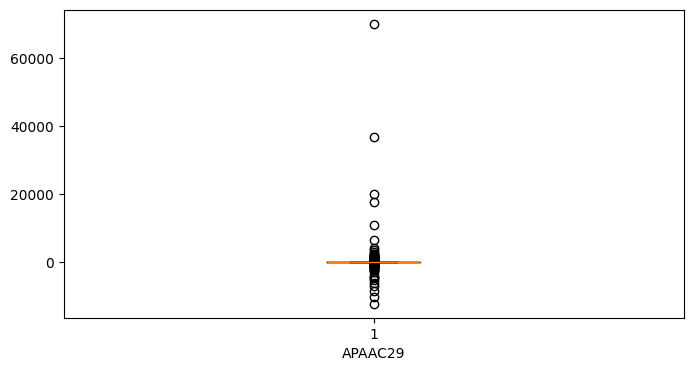

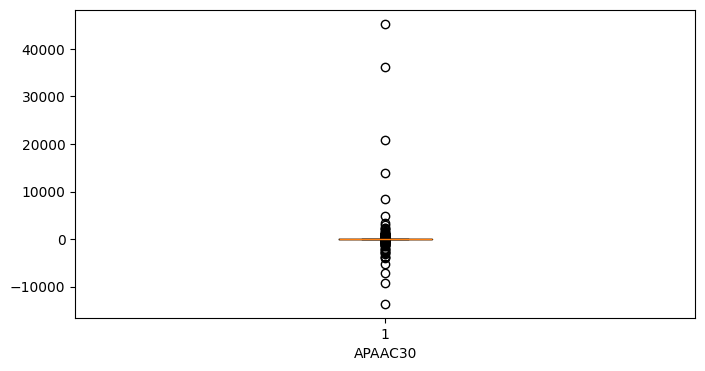

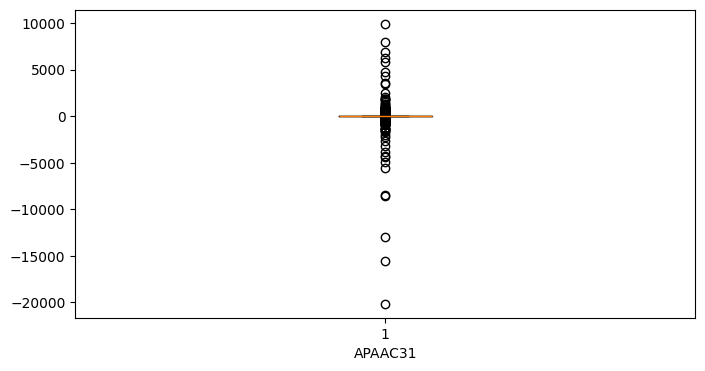

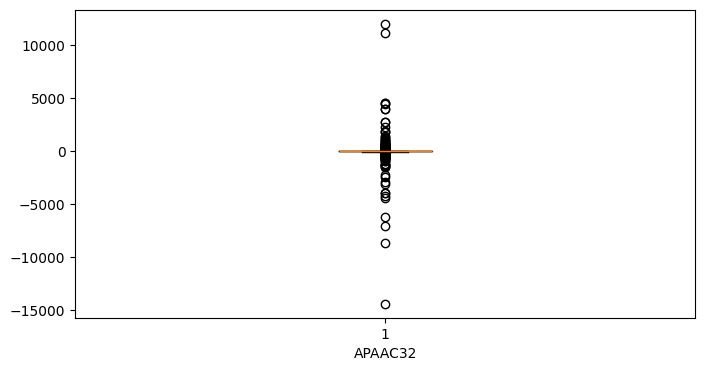

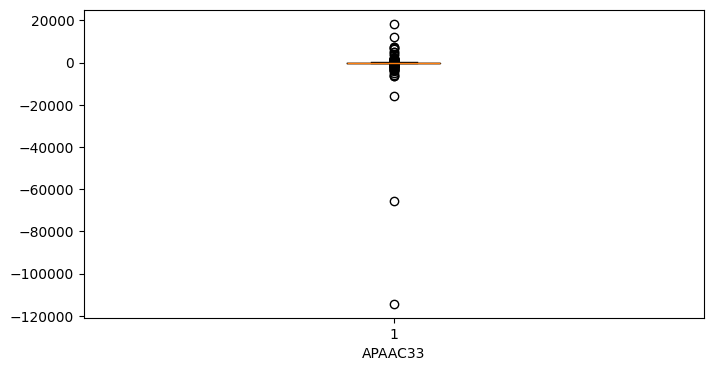

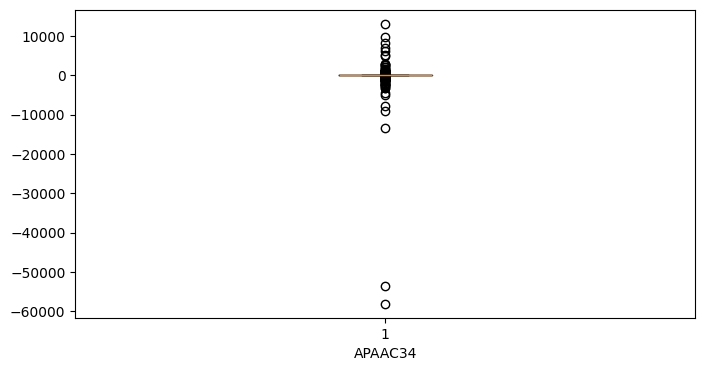

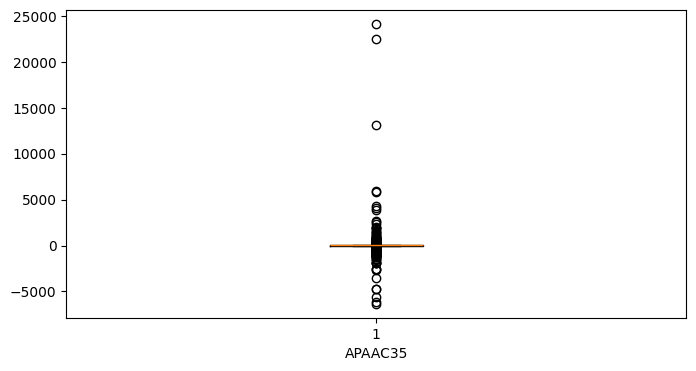

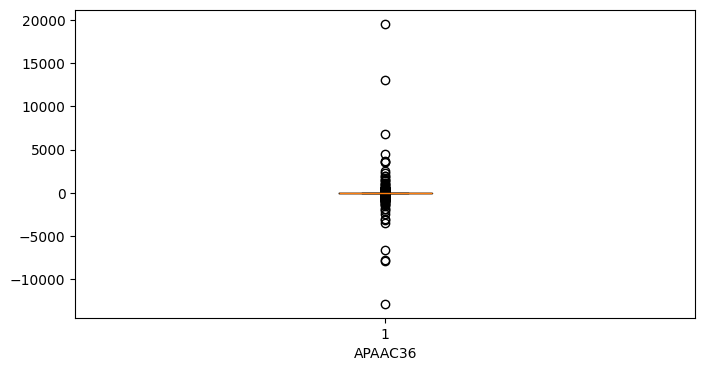

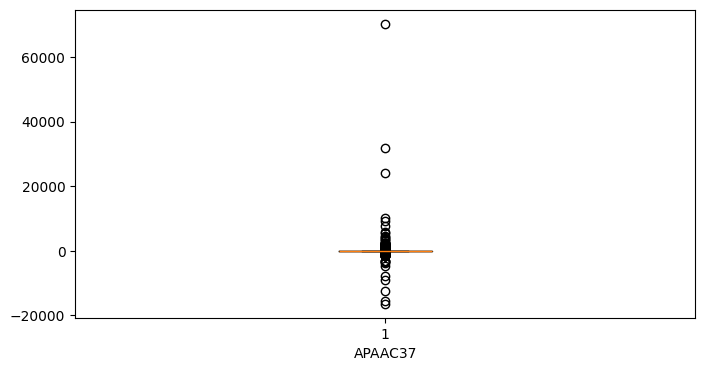

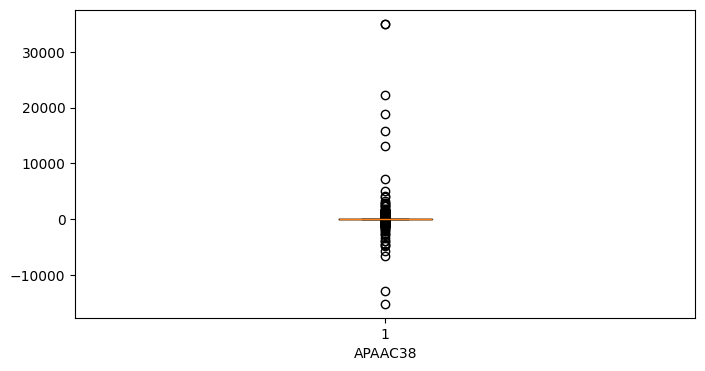

File: aac_pseaac.csv


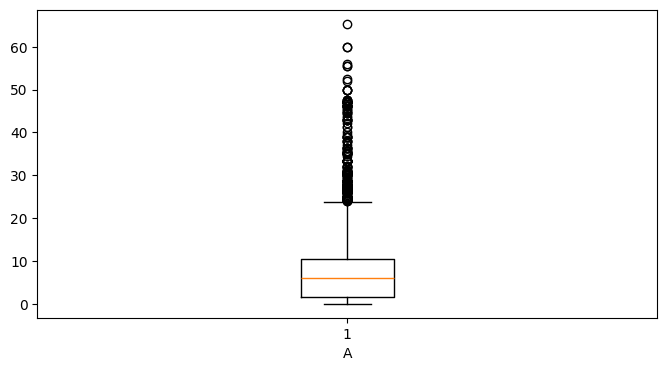

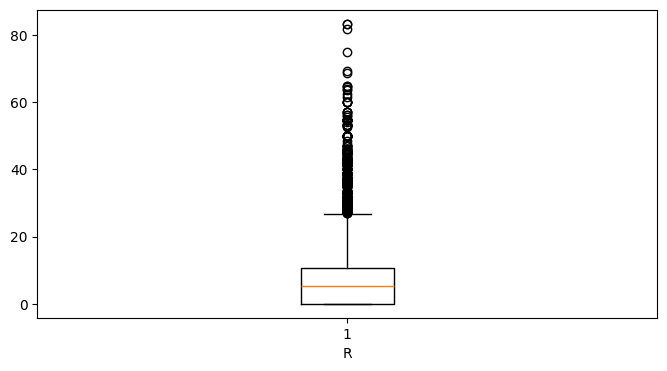

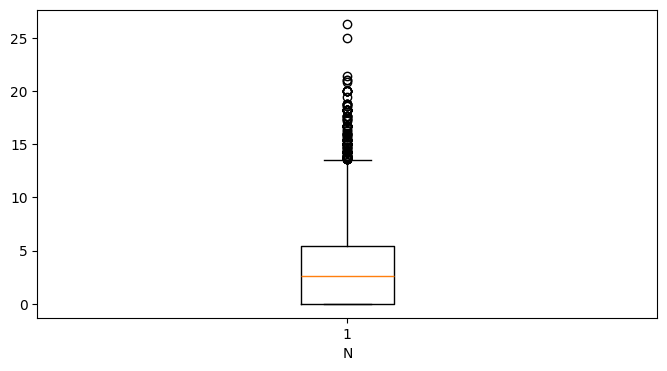

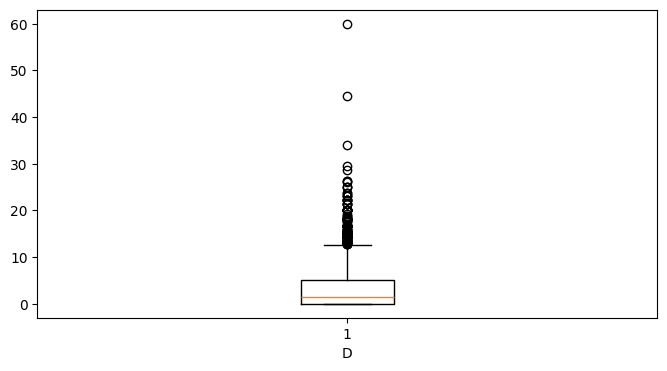

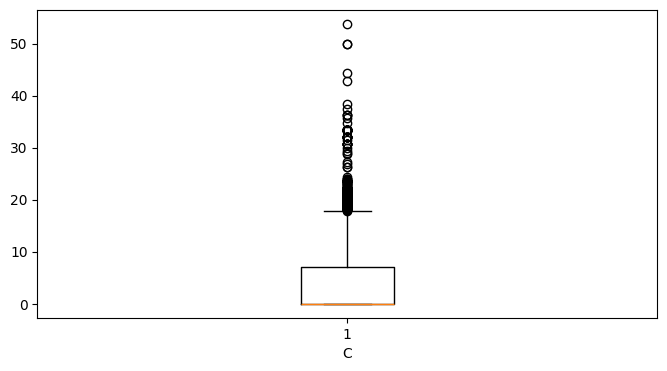

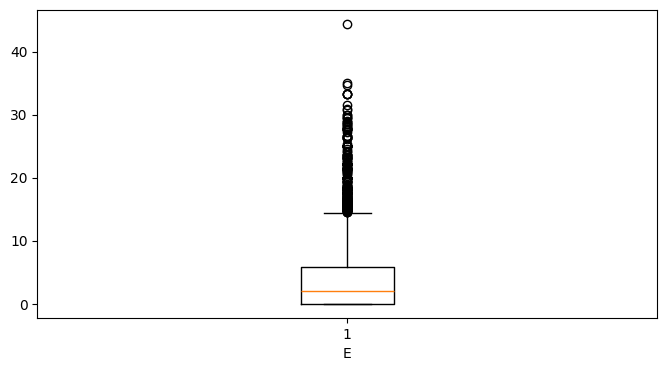

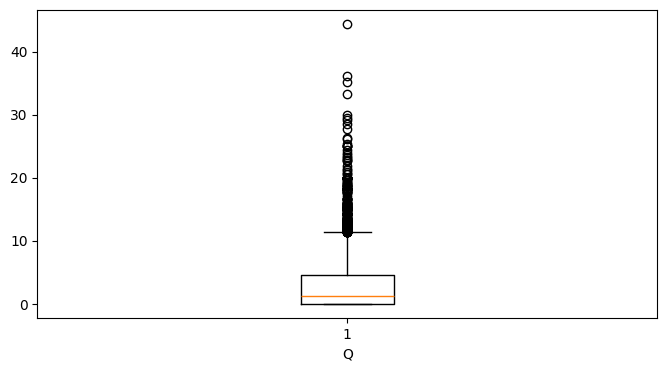

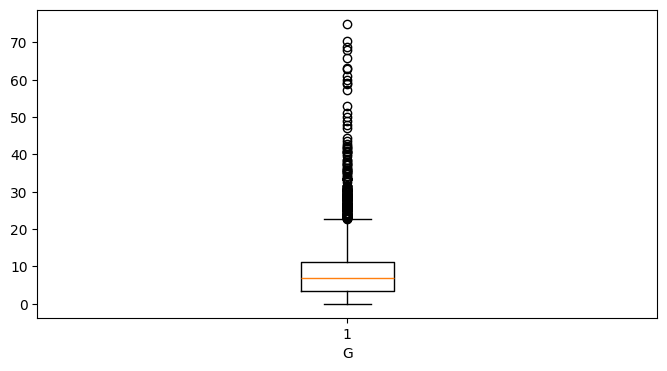

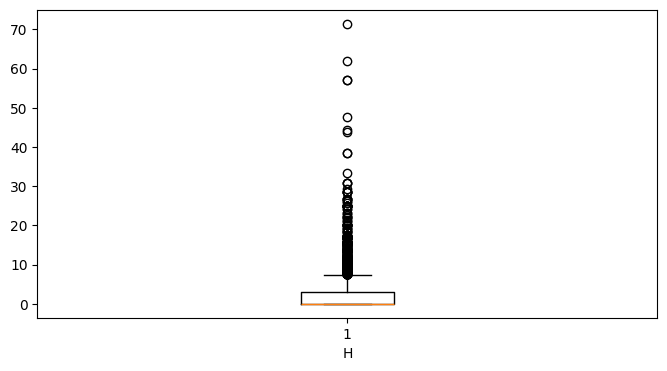

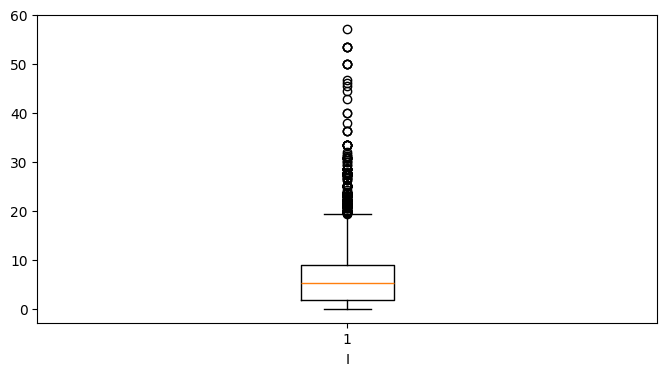

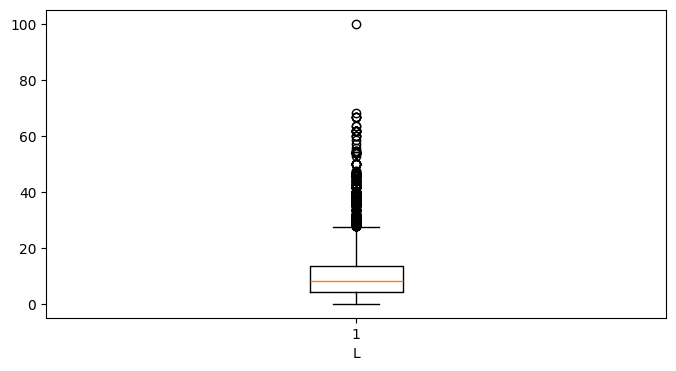

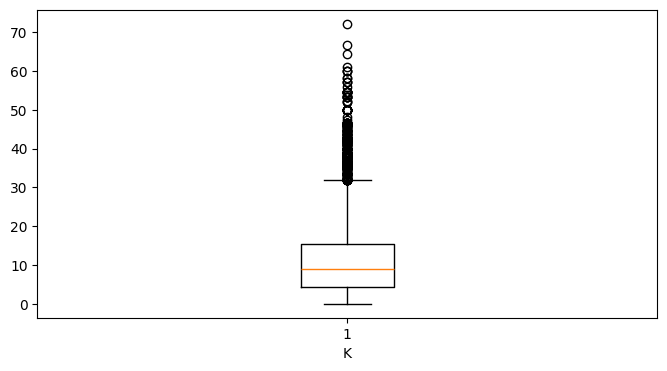

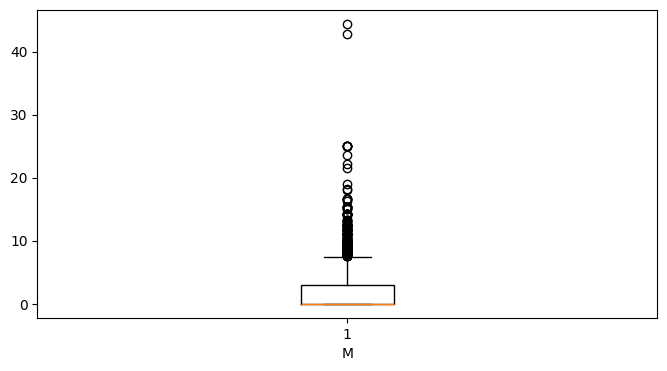

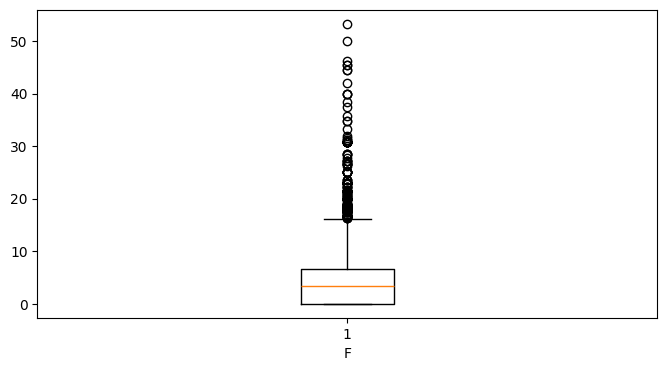

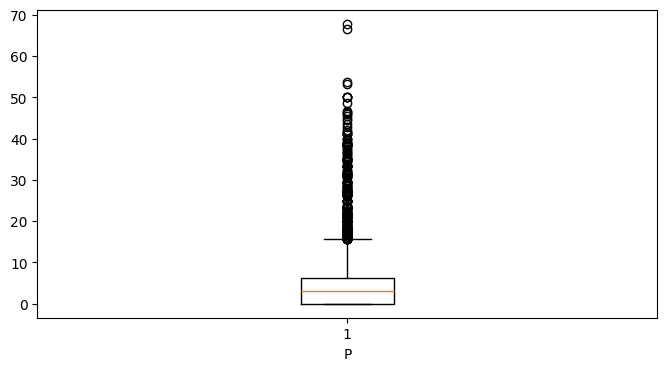

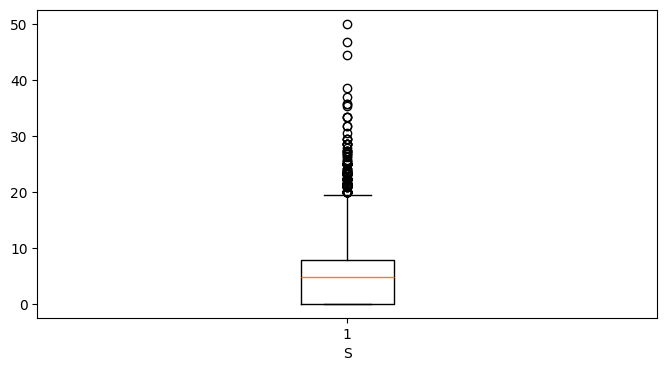

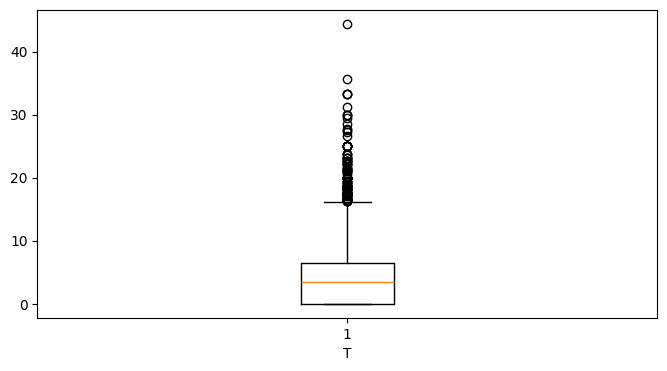

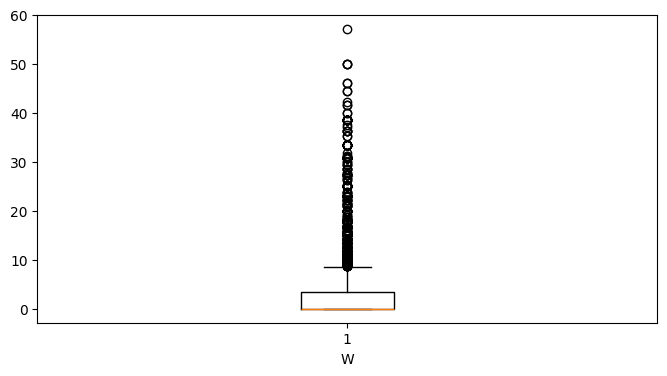

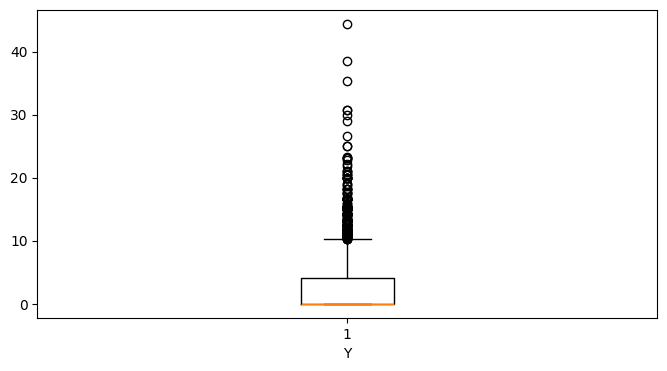

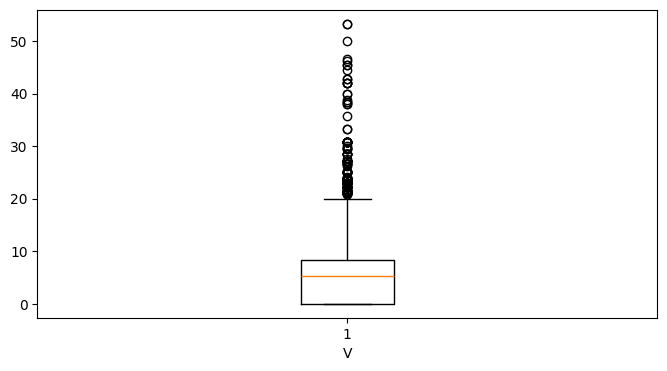

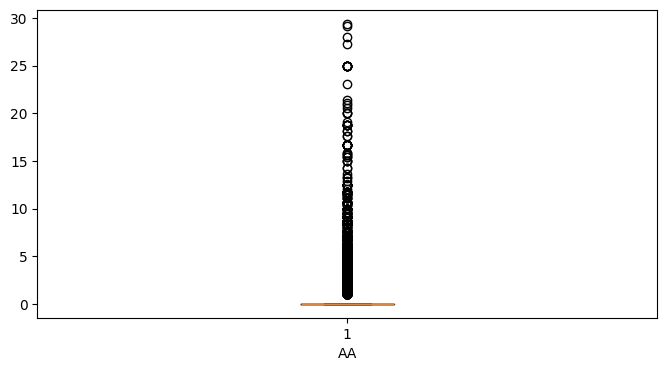

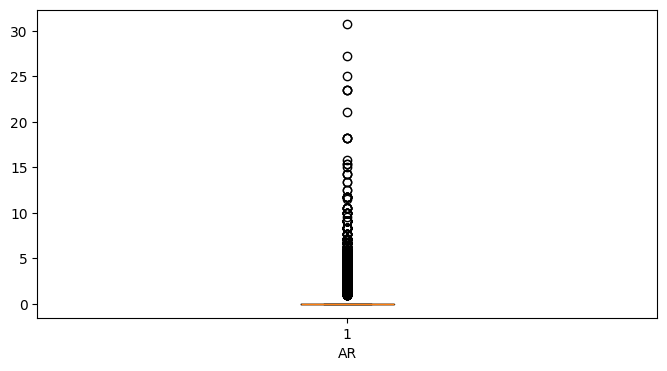

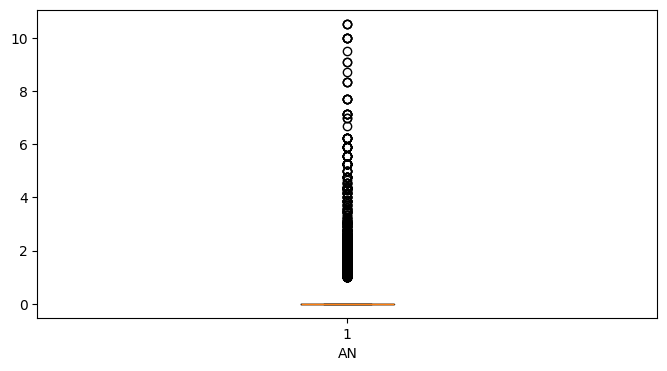

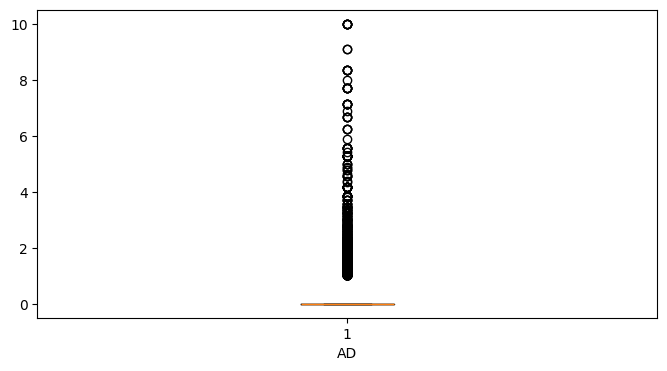

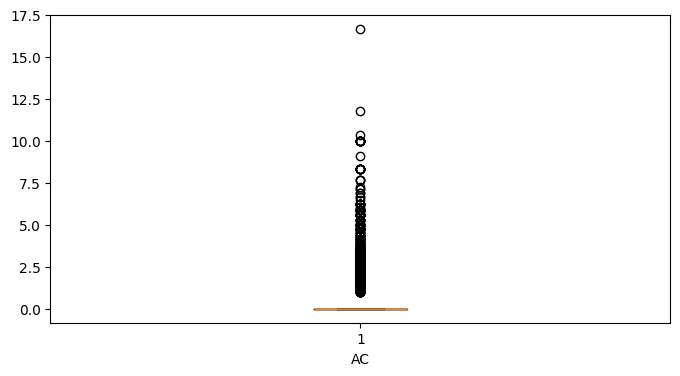

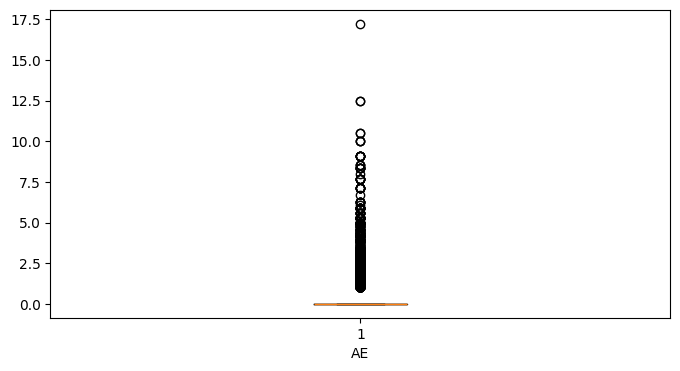

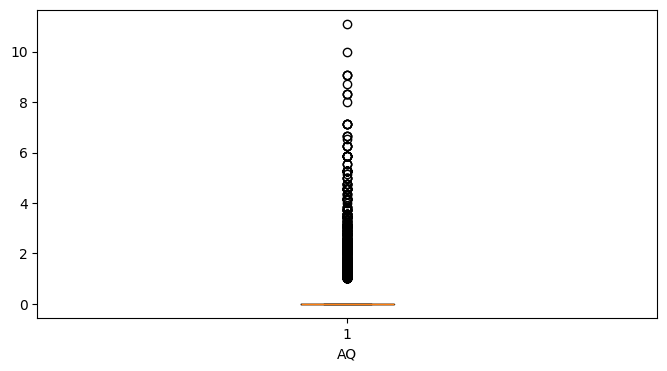

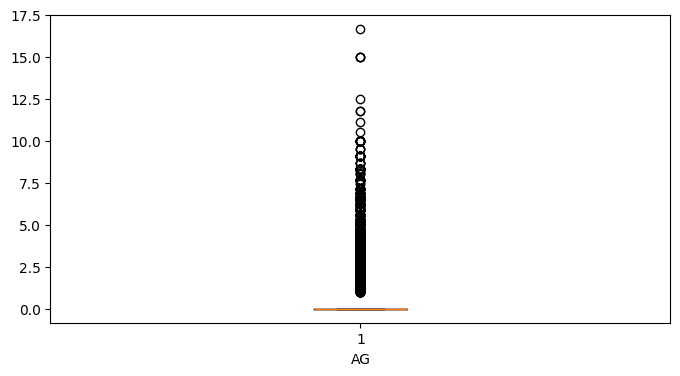

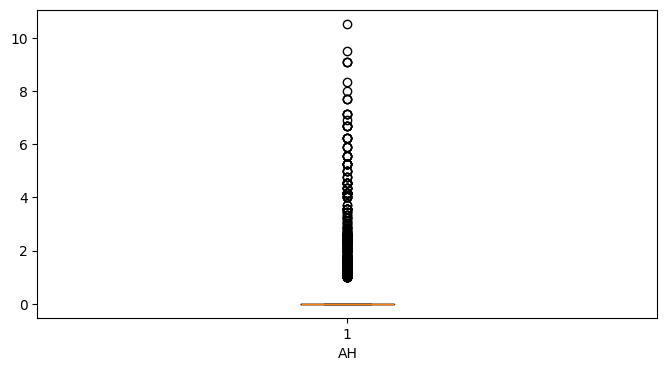

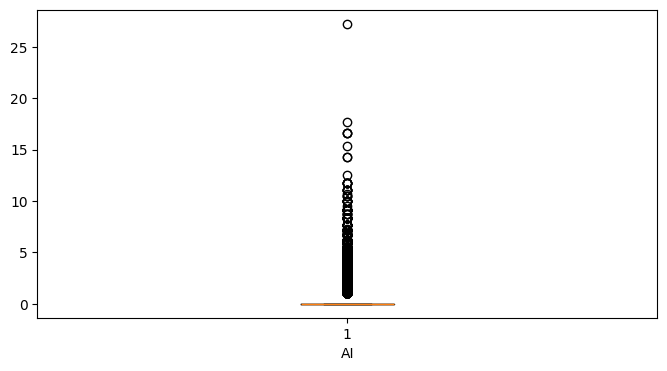

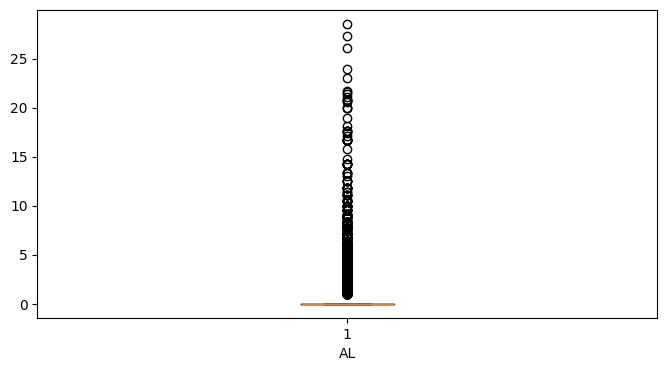

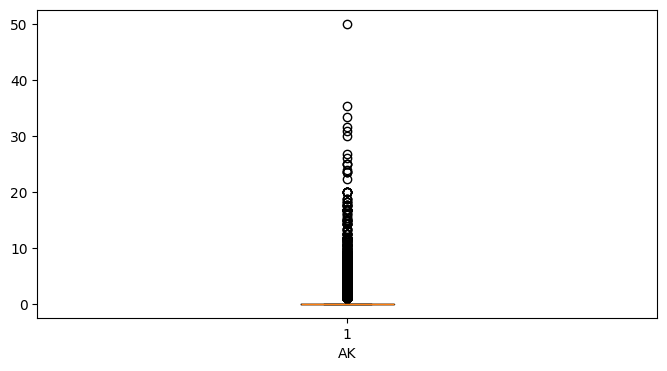

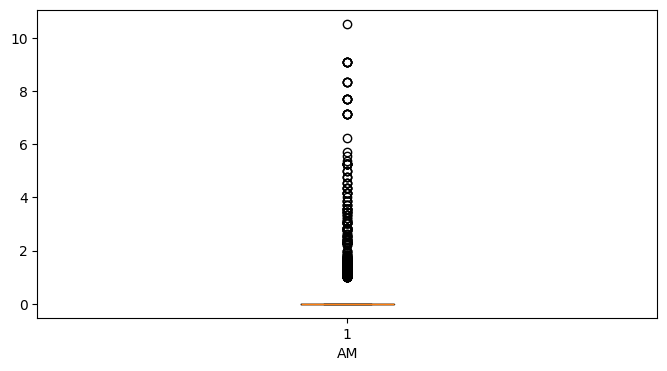

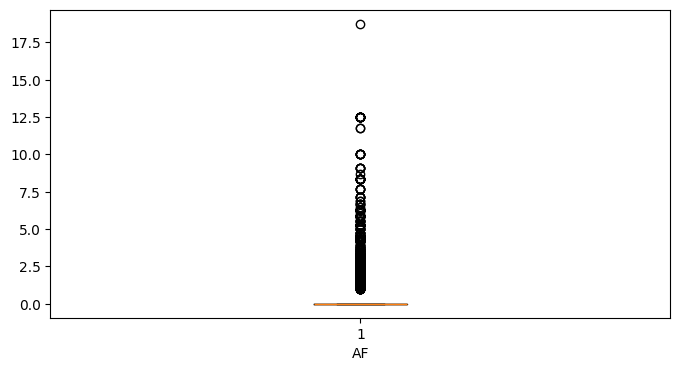

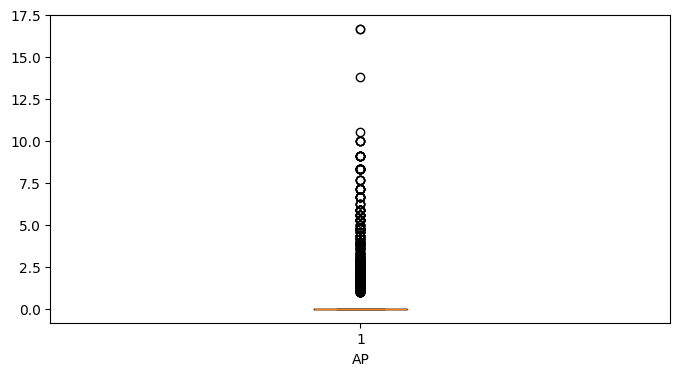

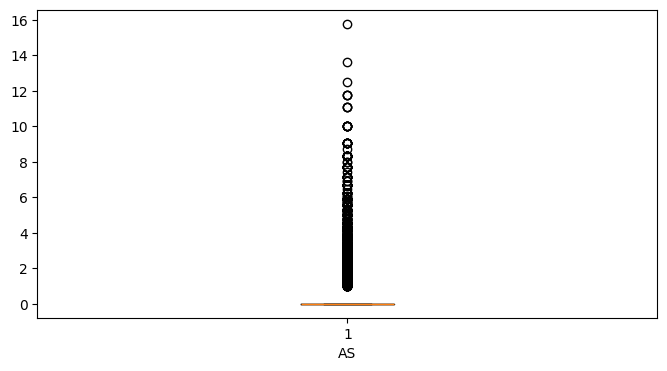

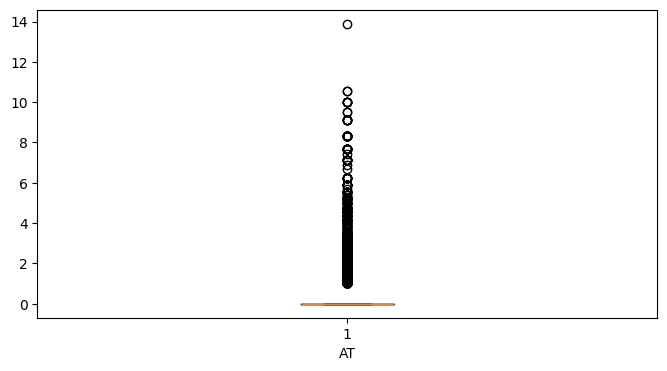

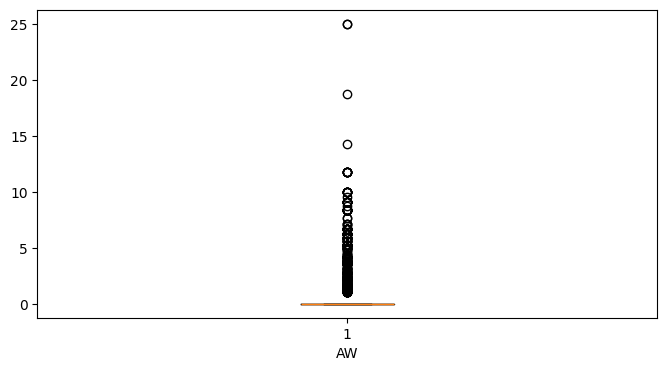

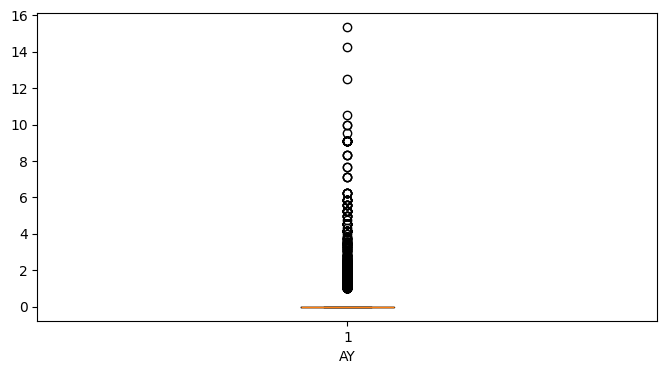

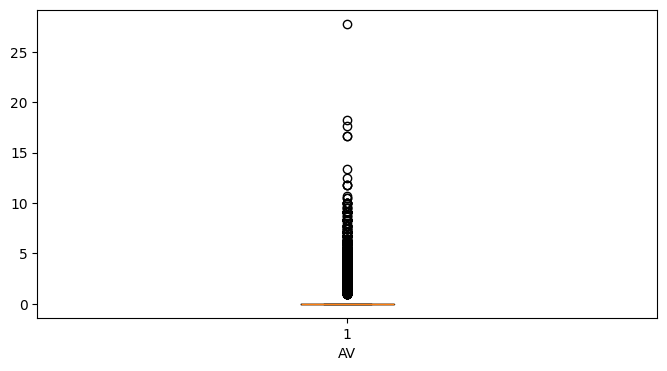

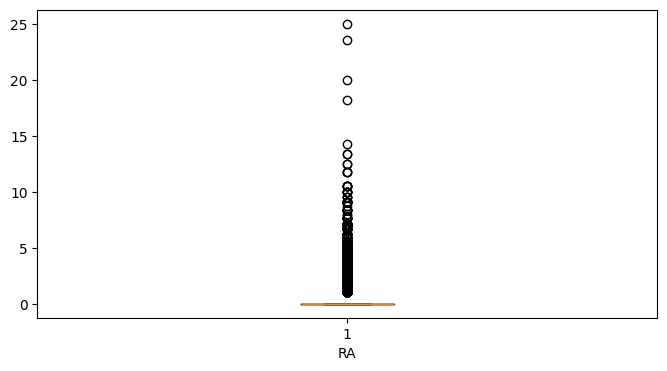

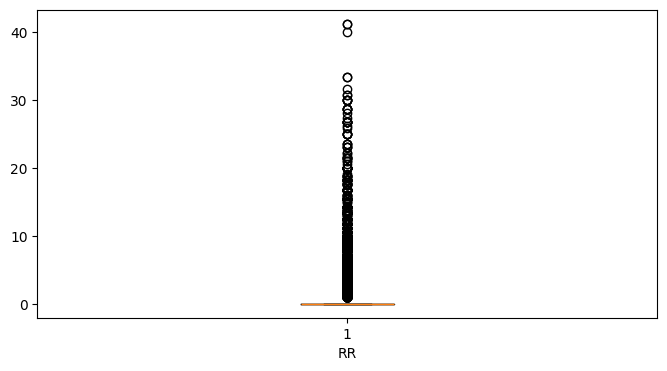

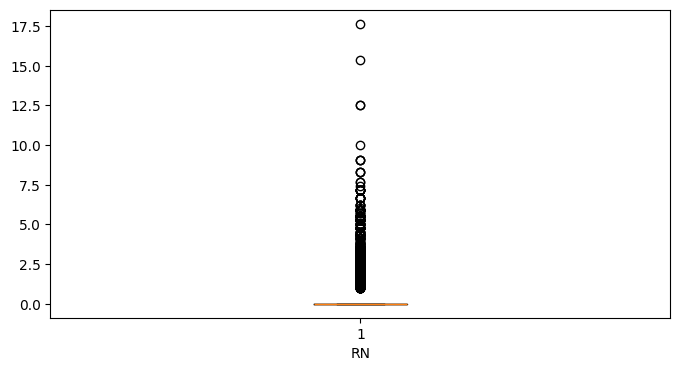

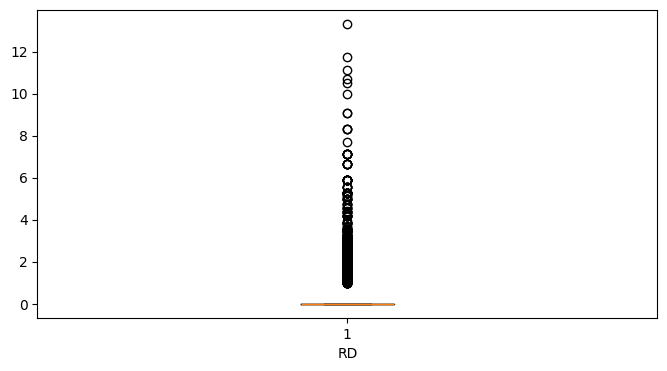

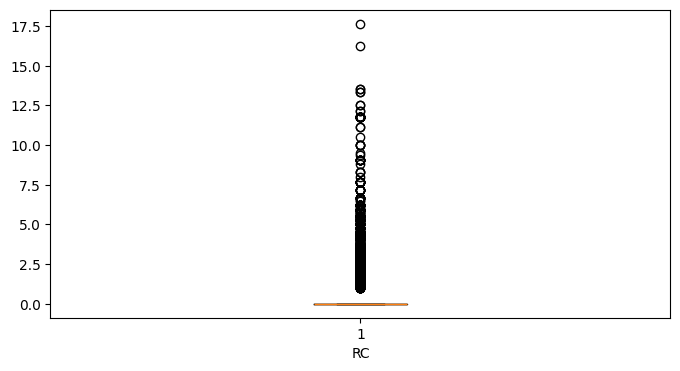

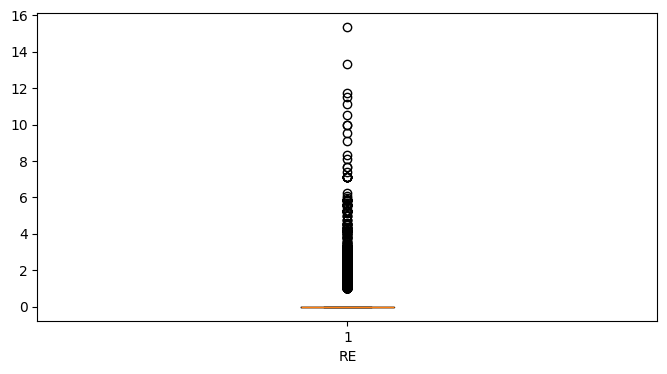

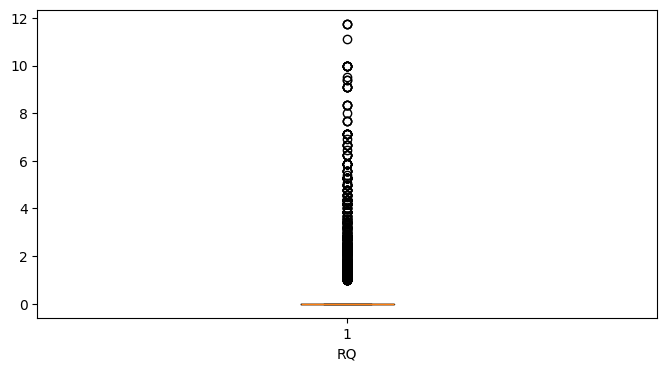

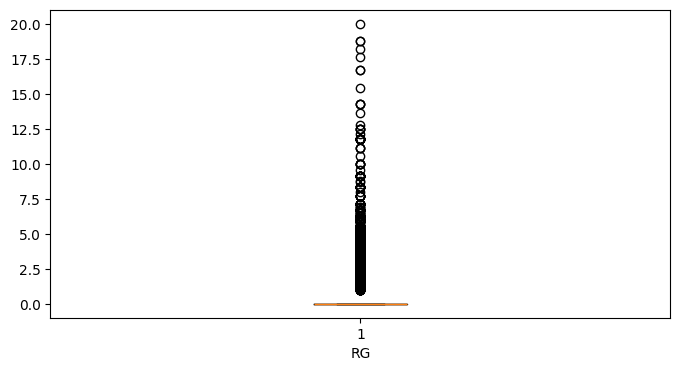

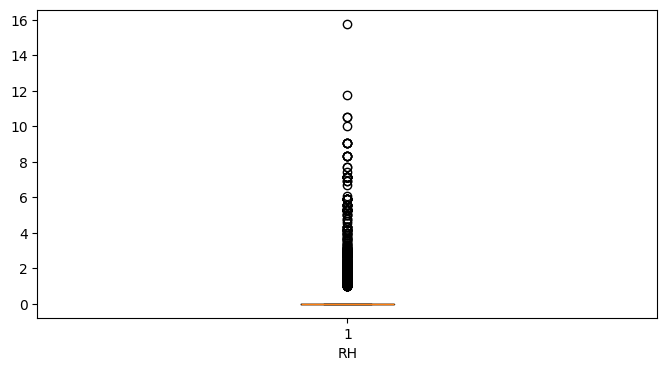

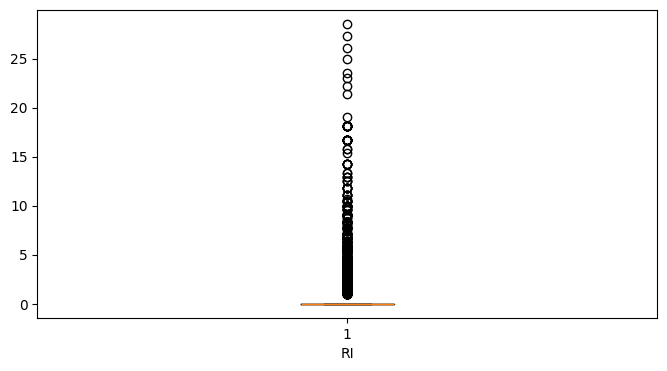

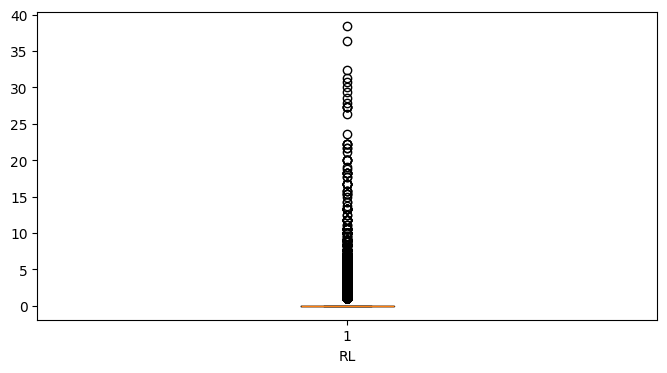

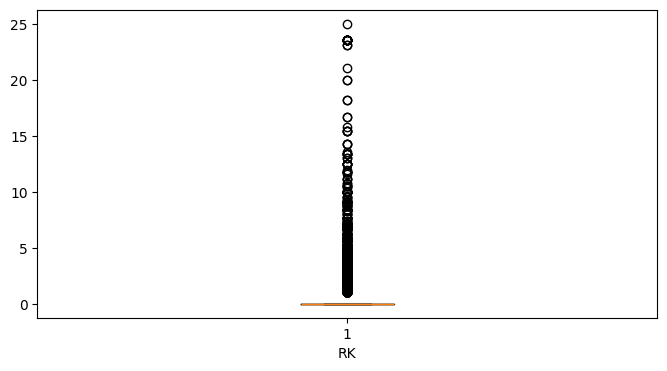

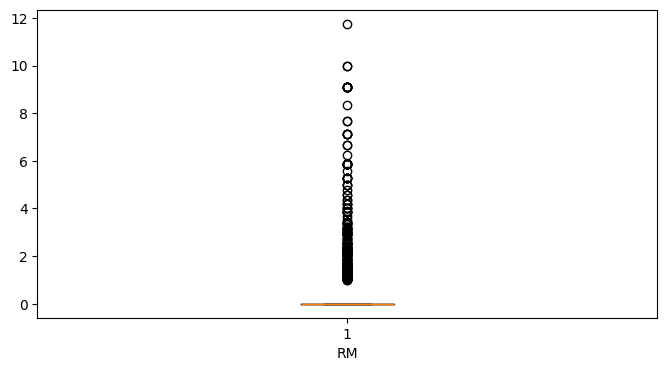

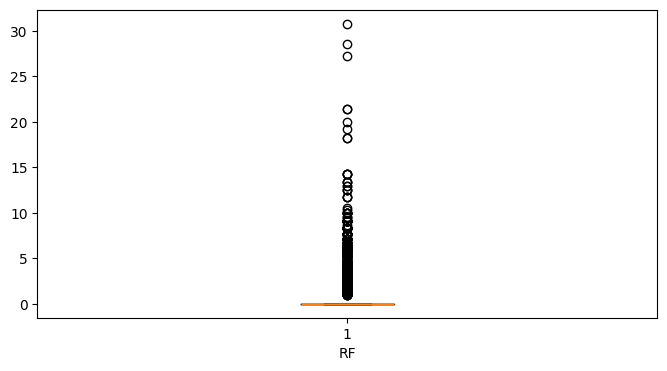

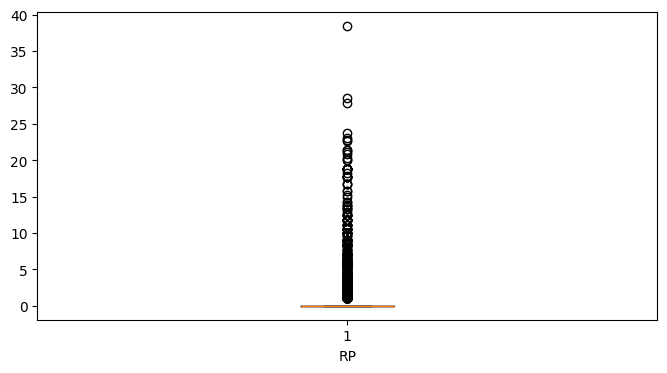

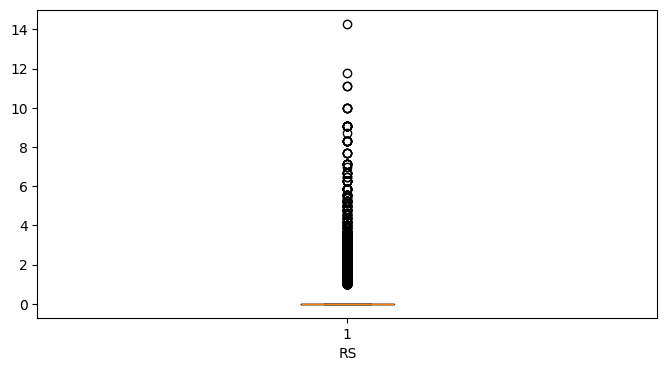

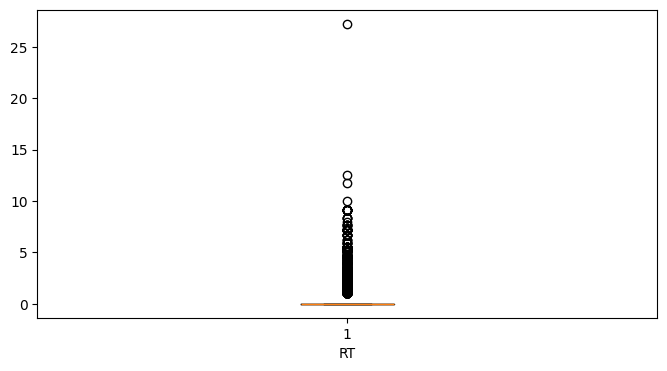

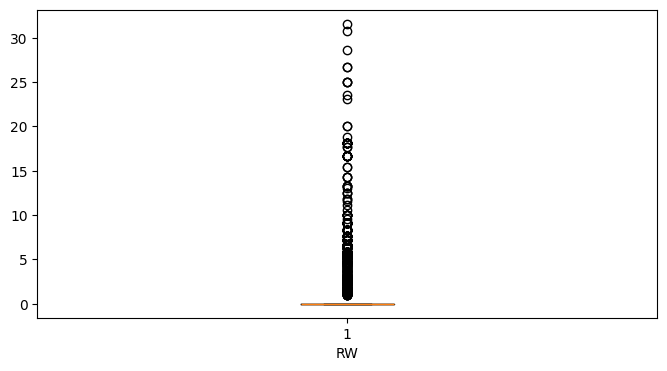

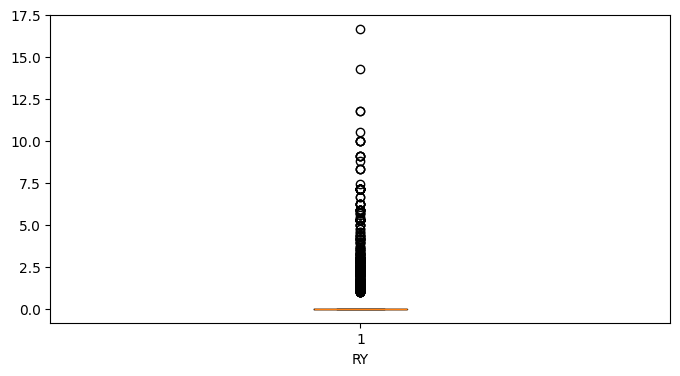

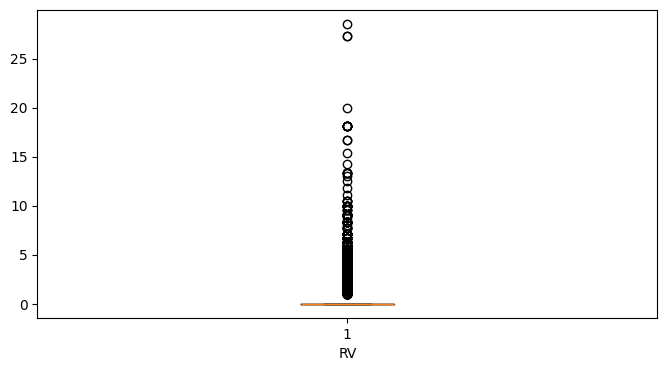

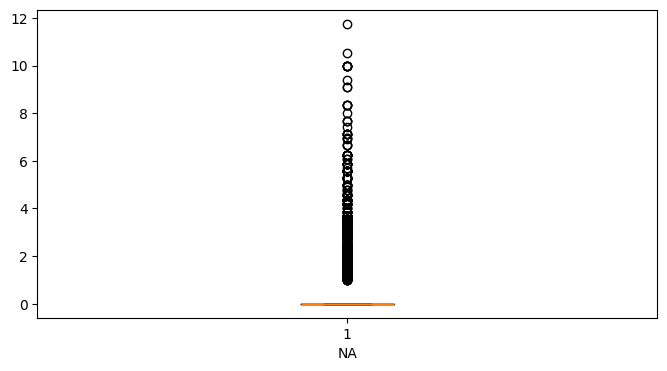

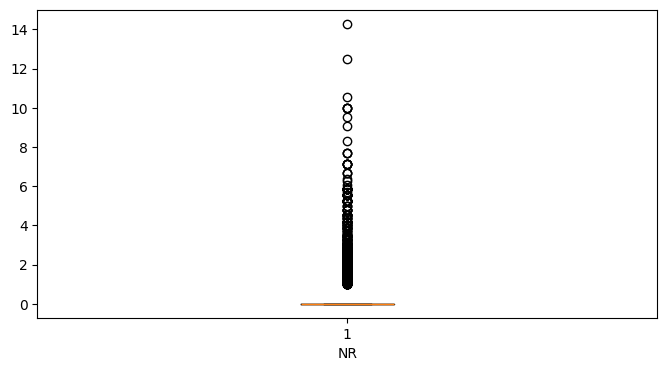

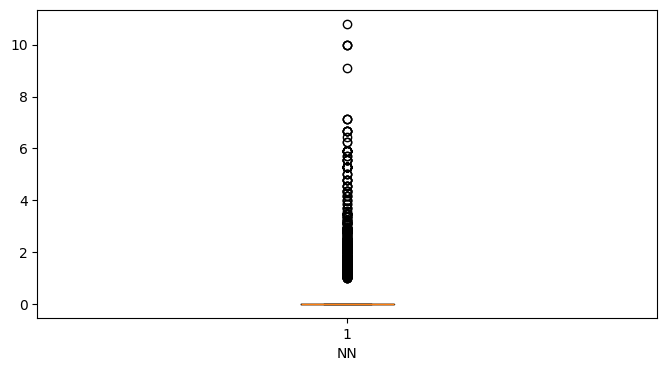

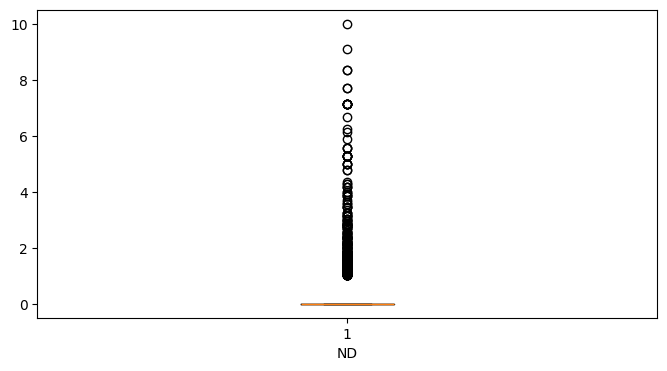

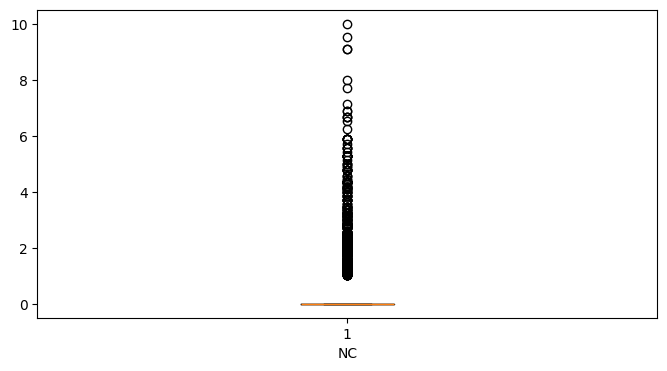

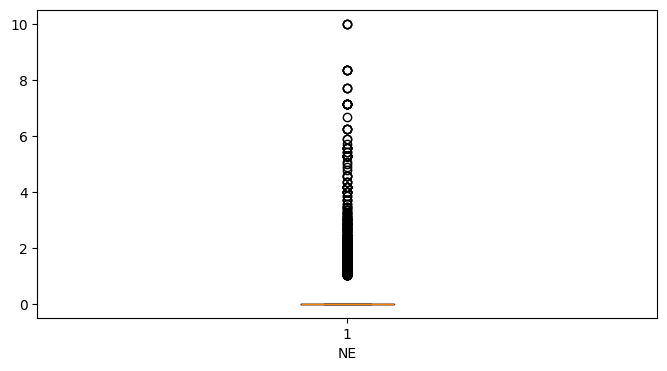

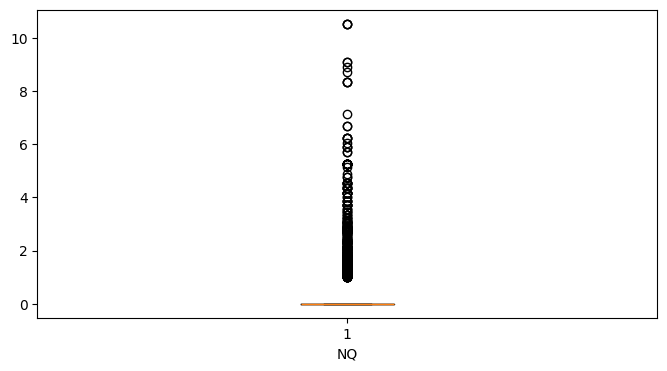

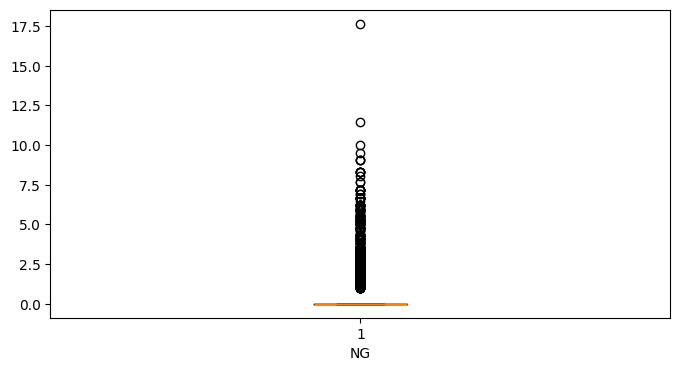

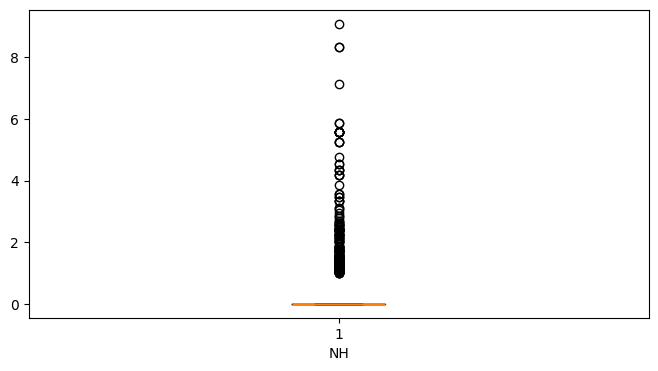

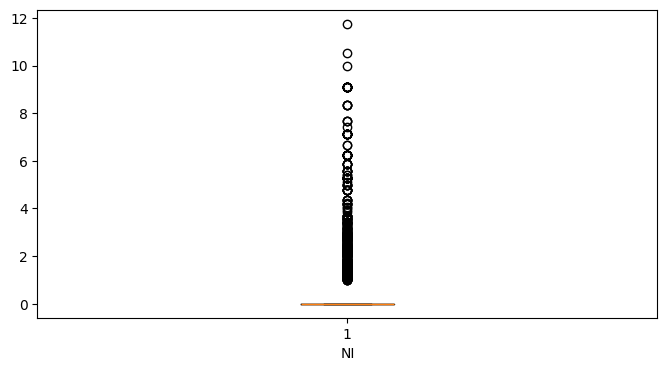

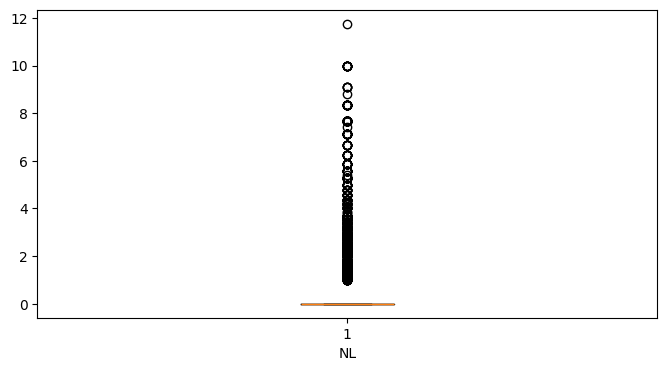

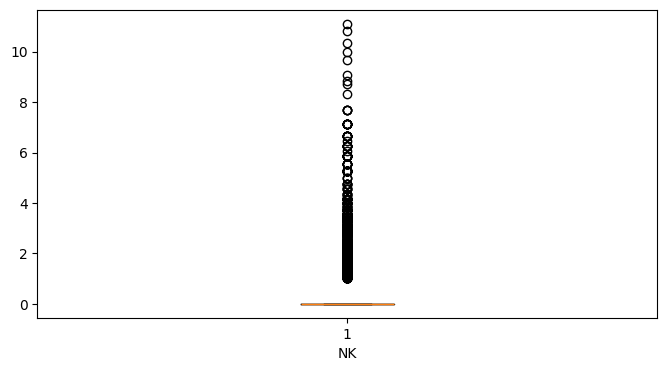

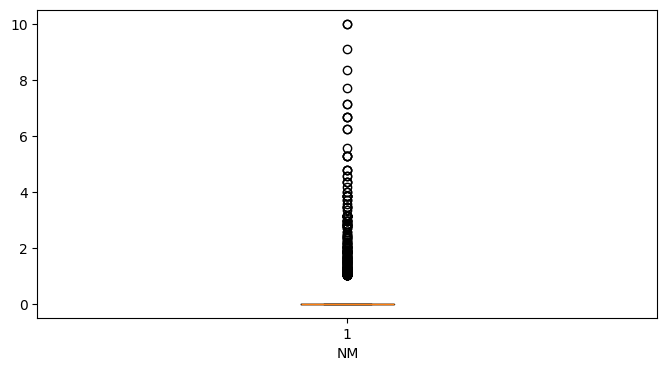

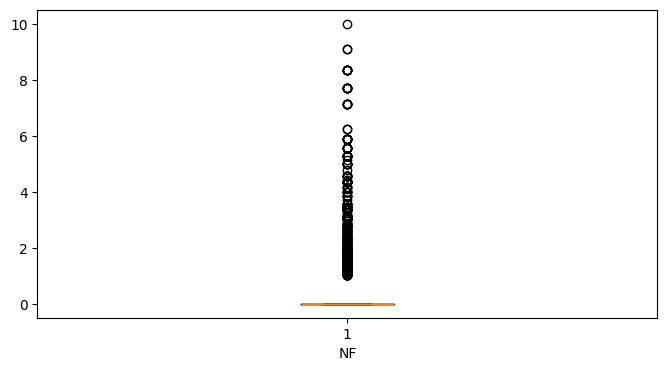

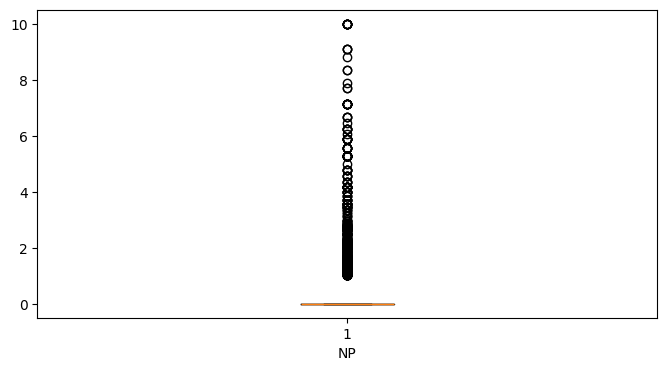

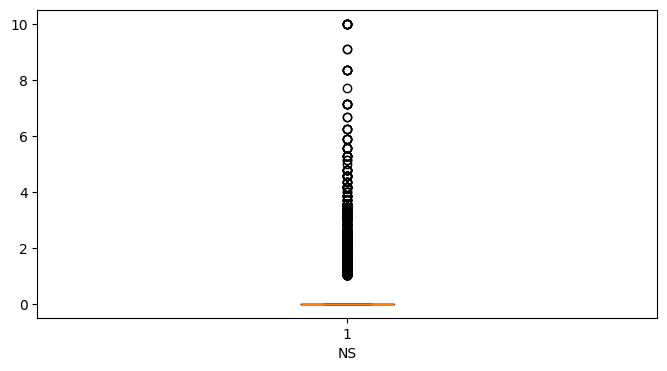

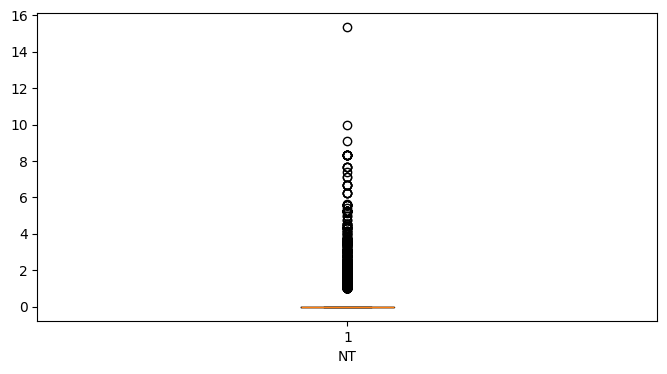

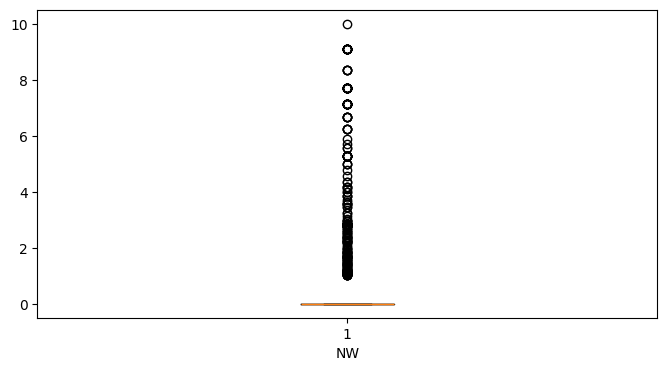

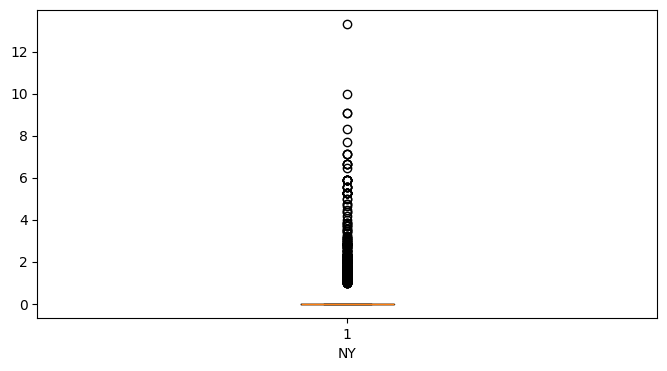

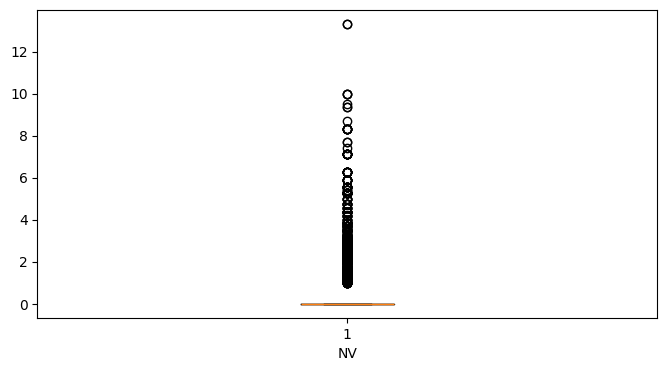

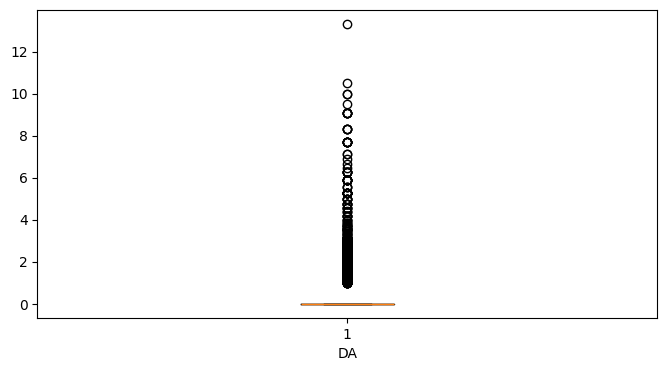

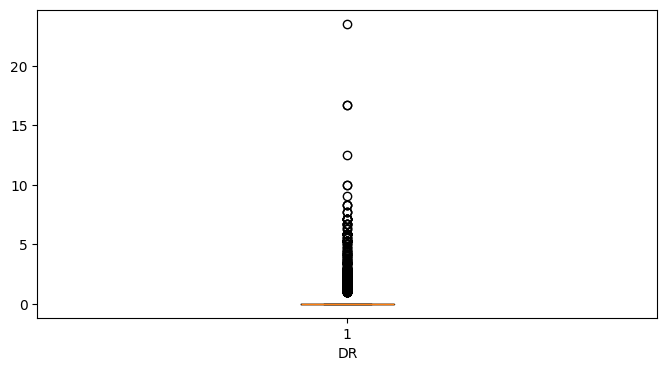

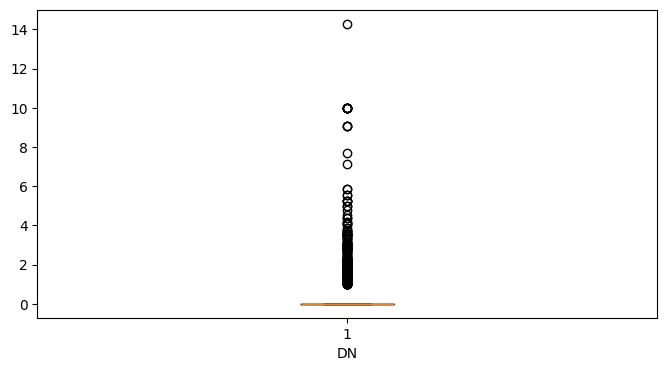

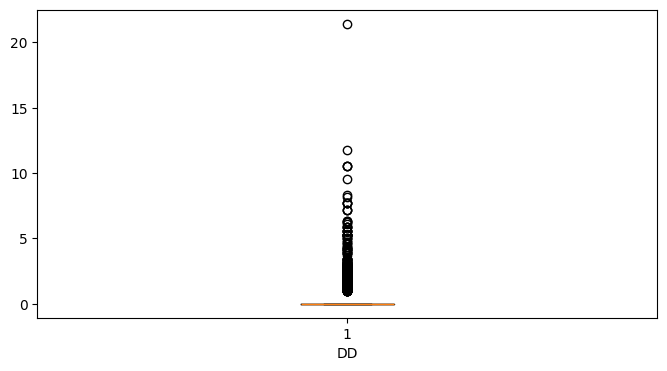

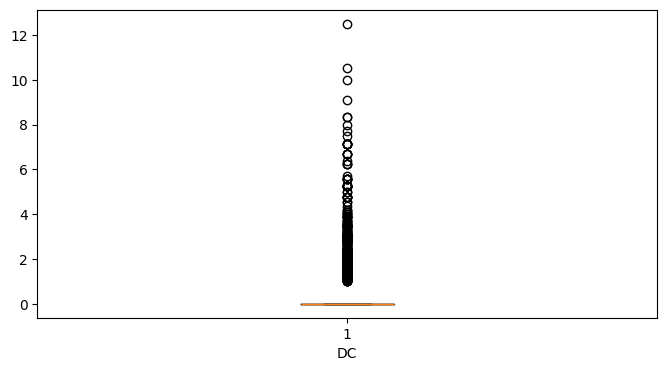

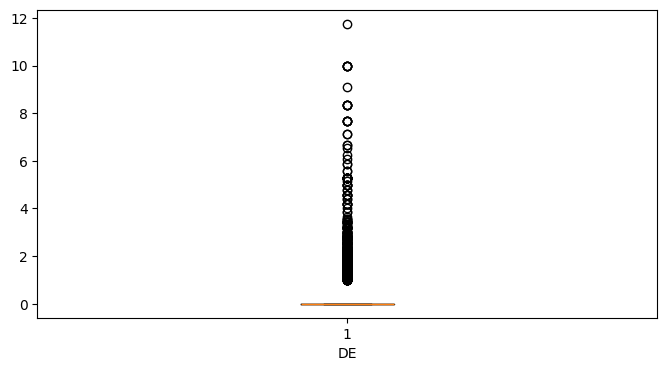

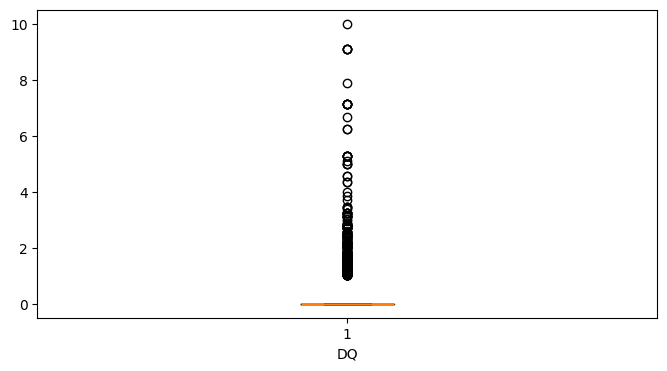

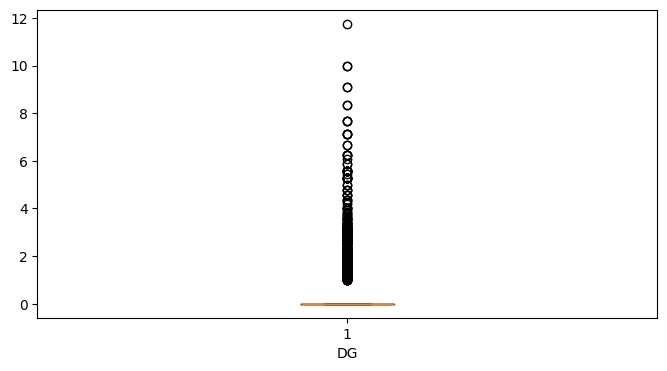

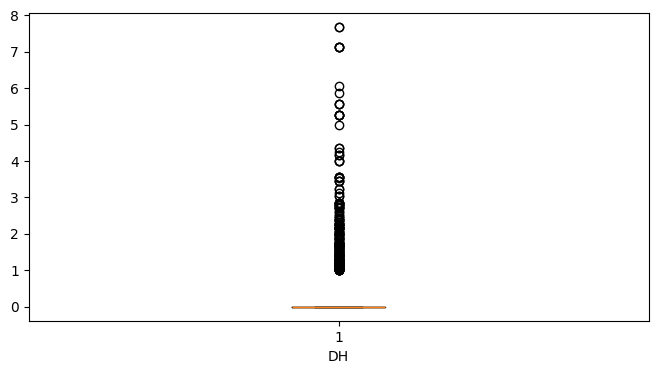

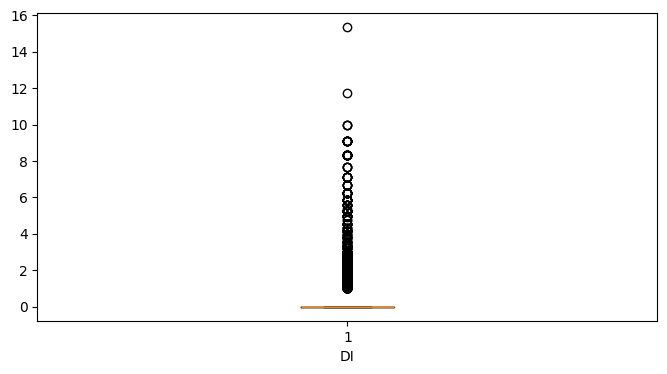

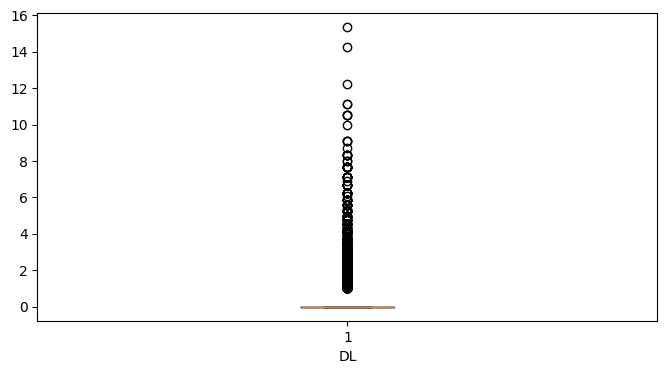

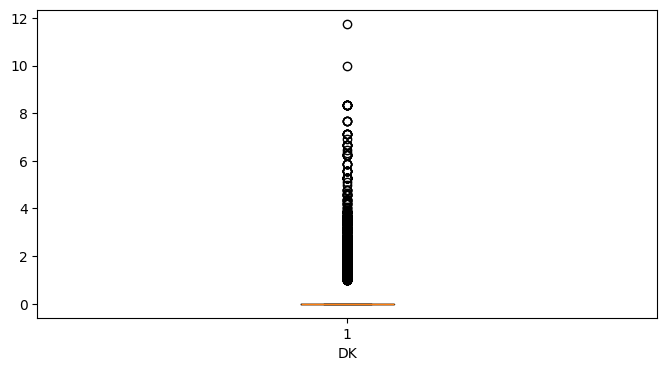

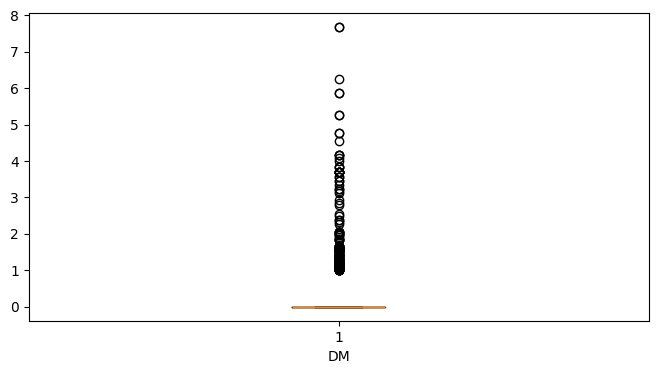

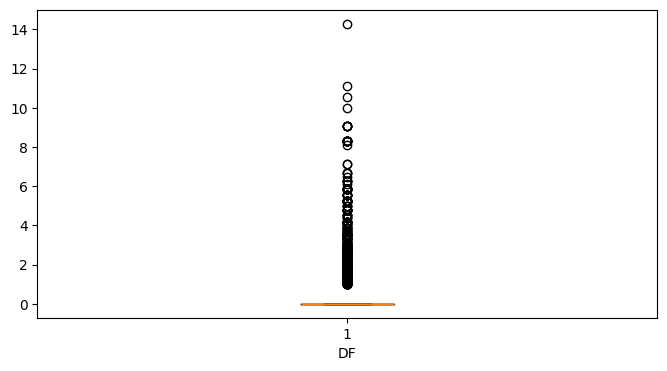

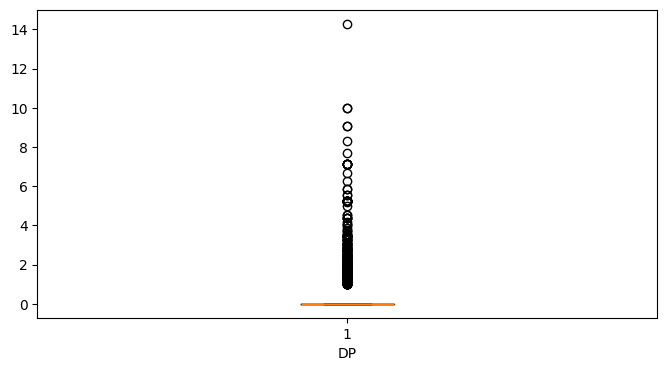

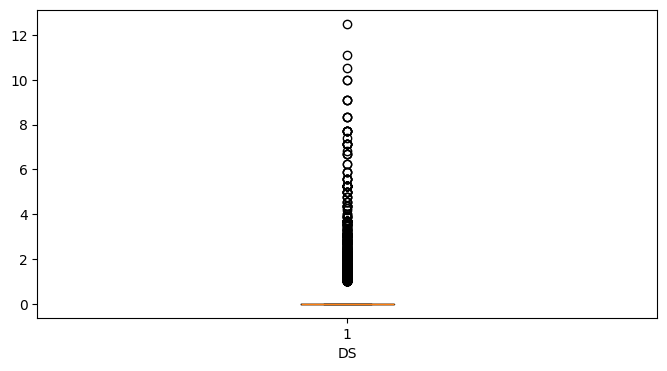

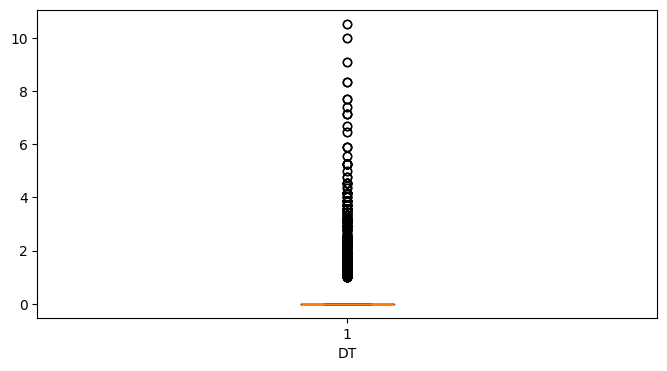

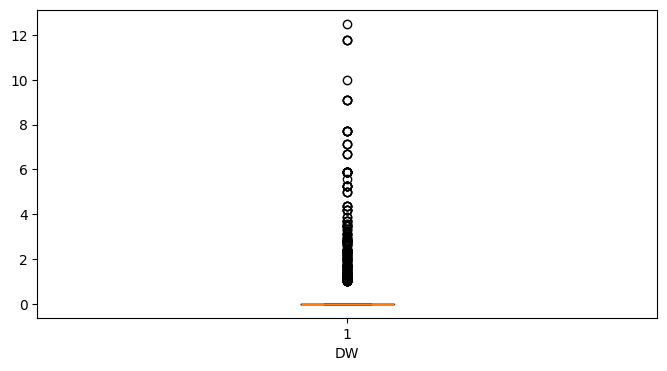

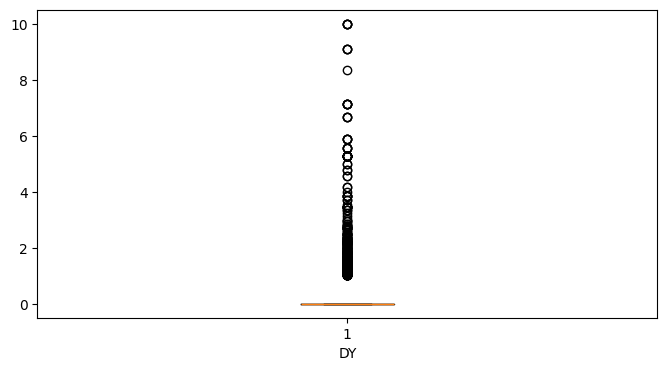

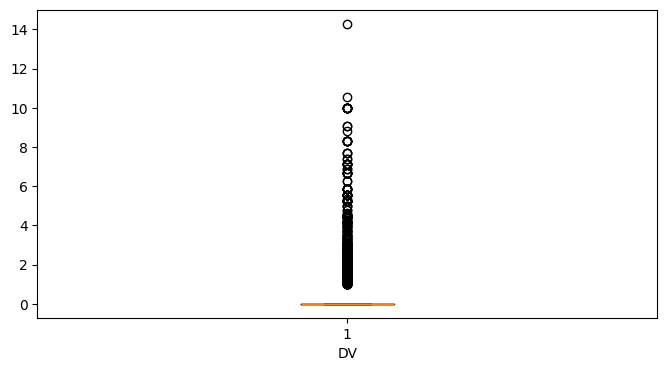

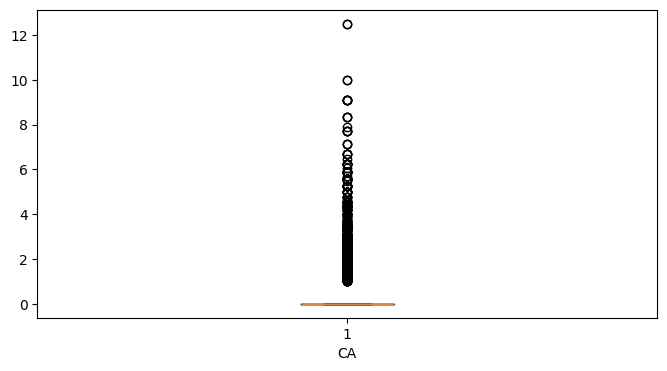

KeyboardInterrupt: 

<Figure size 800x400 with 0 Axes>

In [ ]:
for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(input_dir, file)

        df = pd.read_csv(file_path)
        if "Unnamed: 0" in df.columns:
            df = df.drop("Unnamed: 0", axis=1)

        print("File:", file)
        df = df.iloc[:, 1:-1]

        for col in df:
            plt.figure(figsize=(8, 4))
            plt.boxplot(df[col])
            plt.xlabel(col)
            plt.show()


Distrbution of features

File autocorr_ctd_pseaac.csv


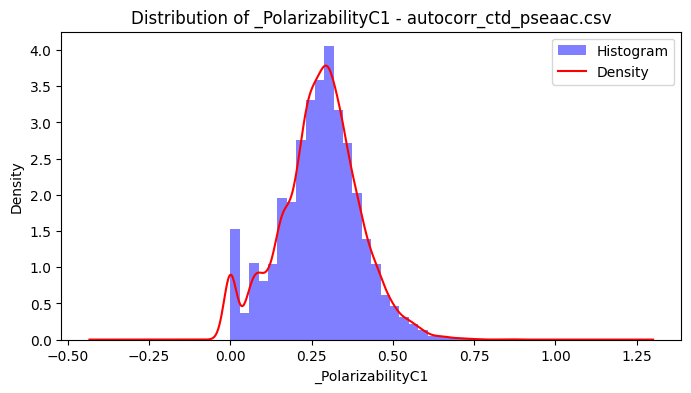

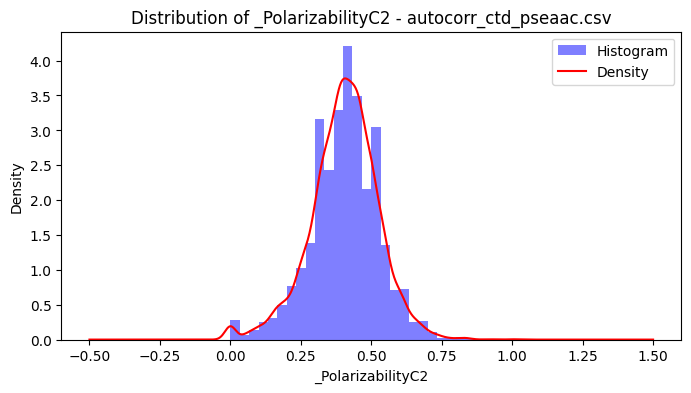

KeyboardInterrupt: 

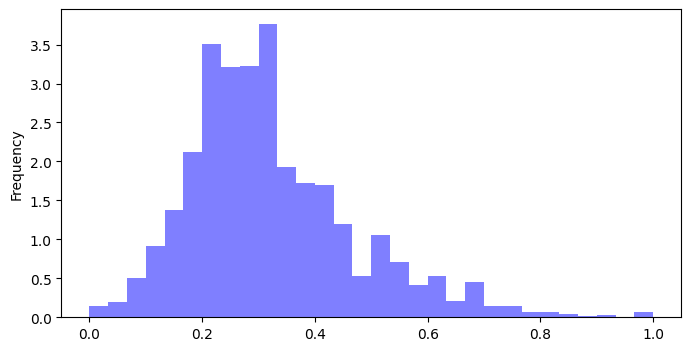

In [ ]:
for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(input_dir, file)

        df = pd.read_csv(file_path)
        if "Unnamed: 0" in df.columns:
            df = df.drop("Unnamed: 0", axis=1)
        df = df.iloc[:, 1:-1]

        print("File", file)

        plot_distributions(df, file)

Normalization & Encoding

In [9]:
for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(input_dir, file)
        df = pd.read_csv(file_path)
        df = df.drop('Activity', axis=1)
        df['Activity'] = label

        output_path = os.path.join('/content/drive/MyDrive/AMPs/Project Data/All combinations/', file)
        df.to_csv(output_path, index=False)

NameError: name 'label' is not defined

In [ ]:
for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(input_dir, file)
        df = pd.read_csv(file_path)
        if "Unnamed: 0" in df.columns:
            df = df.drop("Unnamed: 0", axis=1)

        le = LabelEncoder()

        h = le.fit_transform(df.Activity)
        h = pd.DataFrame(h)
        df = df.drop('Activity', axis=1)
        df['Activity'] = h



        scaler = MinMaxScaler()
        df.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1].astype(float))


        df.to_csv(os.path.join(output_dir, file), index=False)

0    AMP
1    AMP
2    AMP
3    AMP
4    AMP
Name: Activity, dtype: object
File:  pseaac.csv Saved at /content/drive/MyDrive/AMPs/Project Data/Normalized Files
0    AMP
1    AMP
2    AMP
3    AMP
4    AMP
Name: Activity, dtype: object
File:  aac_pseaac.csv Saved at /content/drive/MyDrive/AMPs/Project Data/Normalized Files
0    AMP
1    AMP
2    AMP
3    AMP
4    AMP
Name: Activity, dtype: object
File:  ctd_pseaac.csv Saved at /content/drive/MyDrive/AMPs/Project Data/Normalized Files
0    AMP
1    AMP
2    AMP
3    AMP
4    AMP
Name: Activity, dtype: object
File:  aac.csv Saved at /content/drive/MyDrive/AMPs/Project Data/Normalized Files
0    AMP
1    AMP
2    AMP
3    AMP
4    AMP
Name: Activity, dtype: object
File:  ctd.csv Saved at /content/drive/MyDrive/AMPs/Project Data/Normalized Files
0    AMP
1    AMP
2    AMP
3    AMP
4    AMP
Name: Activity, dtype: object
File:  aac_ctd_pseaac.csv Saved at /content/drive/MyDrive/AMPs/Project Data/Normalized Files
0    AMP
1    AMP
2    AMP
3  

# **Feature Selection**

Sample Model

Filter

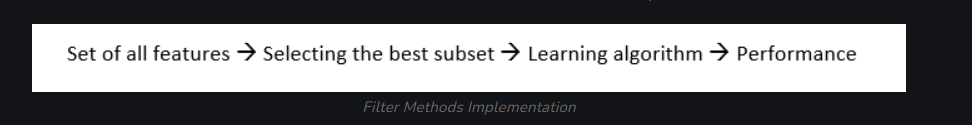


Wrapper
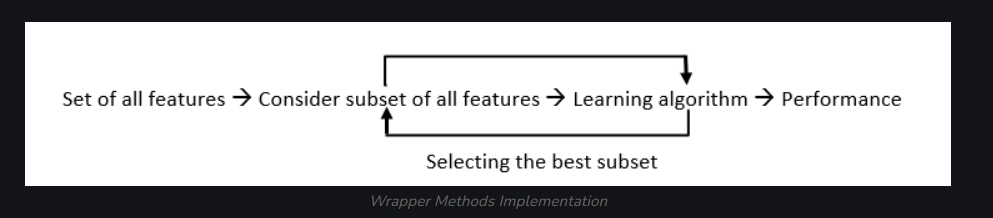

Embedded



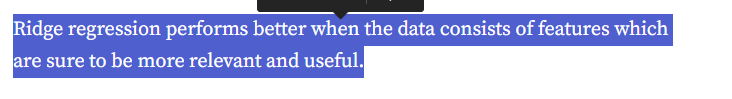

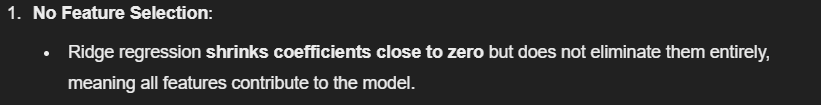

## **Functions of FS**

In [ ]:
def load_and_shuffle_data(file_path):
    df = pd.read_csv(file_path, low_memory=False)
    for col in df.select_dtypes(include=["float", "int"]):
        df[col] = pd.to_numeric(df[col], downcast="float")
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    X = df.iloc[:, 1:-1]
    y = df.iloc[:, -1]
    feature_names = df.columns[1:-1].to_numpy()
    return X, y, feature_names

def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return pd.DataFrame(X_resampled), y_resampled


def variance_threshold_selection(X, feature_names, threshold):
    vt = VarianceThreshold(threshold=threshold)
    vt.fit(X)
    mask = vt.get_support()
    return X.iloc[:, mask], feature_names[mask]


def recursive_feature_elimination(X, y, feature_names):
    rfecv = RFECV(RandomForestClassifier(random_state=42, n_estimators=10), step=0.1,cv=5, scoring='accuracy')
    rfecv.fit(X, y)
    selected_feature_indices = rfecv.support_
    selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_feature_indices[i]]
    X_selected = X.iloc[:, selected_feature_indices]

    return X_selected, selected_feature_names


def sequential_feature_selection(X, y, feature_names):

    boruta = BorutaPy(RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42), n_estimators='auto', random_state=42, max_iter=10)
    boruta.fit(X, y)
    selected_feature_indices = boruta.support_
    selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_feature_indices[i]]
    X_selected = X[selected_feature_names]

    return X_selected, selected_feature_names



def random_forest_feature_importance(X, y, feature_names):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=feature_names)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    thresh = np.mean(importances)

    mask = importances > thresh

    selected_features_X = X.loc[:, mask]
    selected_features_names = selected_features_X.columns.tolist()

    selected_features_X = selected_features_X.values

    return selected_features_X, selected_features_names

## **Comb Of 4 FS**

In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4"

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print(X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print(X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print(X.shape)

    # Concatenate selected features from all steps
    selected_features_combined = pd.concat([pd.DataFrame(X, columns=feature_names[:X.shape[1]]), pd.DataFrame(y, columns=['Activity'])], axis=1)

    # Save the output file
    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT-RFE-SFS-RF_selected_features.csv")
    selected_features_combined.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 38)
(14918, 38)
(14918, 38)
(14918, 11)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4/pseaac_VT-RFE-SFS-RF_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 406)
(14918, 206)
(14918, 206)
(14918, 42)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4/aac_pseaac_VT-RFE-SFS-RF_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 137)
(14918, 137)
(14918, 137)
(14918, 22)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4/ctd_pseaac_VT-RFE-SFS-RF_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 406)
(14918, 206)


## **Combs of 3 FS**

In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3"

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print(X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    # Save the output file
    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT-RFE-SFS_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv
(14918, 38)
(14918, 38)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 38)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/pseaac_VT-RFE-SFS_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 406)
(14918, 280)
(14918, 112)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_pseaac_VT-RFE-SFS_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 137)
(14918, 137)
(14918, 137)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/ctd_pseaac_VT-RFE-SFS_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 406)
(14918, 280)
(14918, 112)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_VT-RFE-SFS_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 137)
(14918, 137)
(14918, 137)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/ctd_VT-RFE-SFS_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 151)
(14918, 151)
(14918, 136)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_ctd_pseaac_VT-RFE-SFS_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 972)
(14918, 443)
(14918, 355)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_VT-RFE-SFS_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 582)
(14918, 394)
(14918, 277)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_pseaac_VT-RFE-SFS_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 151)
(14918, 151)
(14918, 91)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_ctd_VT-RFE-SFS_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 972)
(14918, 443)
(14918, 355)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_pseaac_VT-RFE-SFS_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 307)
(14918, 255)
(14918, 80)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_ctd_VT-RFE-SFS_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 307)
(14918, 255)
(14918, 80)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_ctd_pseaac_VT-RFE-SFS_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 582)
(14918, 402)
(14918, 242)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_VT-RFE-SFS_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 320)
(14918, 242)
(14918, 242)


<ipython-input-18-8467d6e8a8b6>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_data['Activity'] = y


Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_ctd_pseaac_VT-RFE-SFS_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 320)


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print(X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print(X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print(X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT-RFE-RF_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv
(14918, 38)
(14918, 38)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 11)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/pseaac_VT-RFE-RF_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 406)
(14918, 206)
(14918, 42)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_pseaac_VT-RFE-RF_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 137)
(14918, 137)
(14918, 22)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/ctd_pseaac_VT-RFE-RF_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 406)
(14918, 206)
(14918, 42)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_VT-RFE-RF_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 137)
(14918, 137)
(14918, 21)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/ctd_VT-RFE-RF_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 151)
(14918, 136)
(14918, 24)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_ctd_pseaac_VT-RFE-RF_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 972)
(14918, 681)
(14918, 100)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_VT-RFE-RF_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 582)
(14918, 292)
(14918, 50)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_pseaac_VT-RFE-RF_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 151)
(14918, 91)
(14918, 13)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_ctd_VT-RFE-RF_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 972)
(14918, 681)
(14918, 100)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_pseaac_VT-RFE-RF_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 307)
(14918, 127)
(14918, 24)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_ctd_VT-RFE-RF_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 307)
(14918, 127)
(14918, 24)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_ctd_pseaac_VT-RFE-RF_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 582)
(14918, 408)
(14918, 68)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_VT-RFE-RF_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 320)
(14918, 192)
(14918, 33)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_ctd_pseaac_VT-RFE-RF_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 320)
(14918, 64)
(14918, 15)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_ctd_VT-RFE-RF_selected_features.csv
This Comb on all DFs is Done


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print(X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT-SFS-RF_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv
(14918, 38)
(14918, 38)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 11)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/pseaac_VT-SFS-RF_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 406)
(14918, 280)
(14918, 54)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_pseaac_VT-SFS-RF_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 137)
(14918, 137)
(14918, 22)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/ctd_pseaac_VT-SFS-RF_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 406)
(14918, 280)
(14918, 54)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_VT-SFS-RF_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 137)
(14918, 137)
(14918, 21)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/ctd_VT-SFS-RF_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 151)
(14918, 151)
(14918, 23)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_ctd_pseaac_VT-SFS-RF_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 972)
(14918, 443)
(14918, 82)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_VT-SFS-RF_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 582)
(14918, 394)
(14918, 67)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_pseaac_VT-SFS-RF_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 151)
(14918, 151)
(14918, 23)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_ctd_VT-SFS-RF_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 972)
(14918, 443)
(14918, 82)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_pseaac_VT-SFS-RF_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 307)
(14918, 255)
(14918, 48)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_ctd_VT-SFS-RF_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 307)
(14918, 255)
(14918, 48)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_ctd_pseaac_VT-SFS-RF_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 582)
(14918, 402)
(14918, 67)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/autocorr_VT-SFS-RF_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 320)
(14918, 242)
(14918, 46)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_ctd_pseaac_VT-SFS-RF_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 320)
(14918, 243)
(14918, 44)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_autocorr_ctd_VT-SFS-RF_selected_features.csv
This Comb on all DFs is Done


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print(X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_RFE-SFS-RF_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


## **Combs of 2 FS**

In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print(X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print(X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT-RFE_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print(X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print(X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT-RF_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv
(14918, 38)
(14918, 38)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 11)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/pseaac_VT-RF_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 406)
(14918, 70)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_pseaac_VT-RF_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 137)
(14918, 22)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/ctd_pseaac_VT-RF_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 406)
(14918, 70)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_VT-RF_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 137)
(14918, 21)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/ctd_VT-RF_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 151)
(14918, 23)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_ctd_pseaac_VT-RF_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 972)
(14918, 129)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_VT-RF_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 582)
(14918, 79)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_pseaac_VT-RF_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 151)
(14918, 23)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_ctd_VT-RF_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 972)
(14918, 129)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_pseaac_VT-RF_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 307)
(14918, 55)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_ctd_VT-RF_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 307)
(14918, 55)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_ctd_pseaac_VT-RF_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 582)
(14918, 82)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_VT-RF_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 320)
(14918, 57)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_ctd_pseaac_VT-RF_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 320)
(14918, 59)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_ctd_VT-RF_selected_features.csv
This Comb on all DFs is Done


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print(X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT-SFS_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 38)
(14918, 38)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/pseaac_VT-SFS_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 406)
(14918, 280)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_pseaac_VT-SFS_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 137)
(14918, 137)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/ctd_pseaac_VT-SFS_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 406)
(14918, 280)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_VT-SFS_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 137)
(14918, 137)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/ctd_VT-SFS_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 151)
(14918, 151)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_ctd_pseaac_VT-SFS_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 972)
(14918, 443)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_VT-SFS_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 582)
(14918, 394)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_pseaac_VT-SFS_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 151)
(14918, 151)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_ctd_VT-SFS_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 972)
(14918, 443)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_pseaac_VT-SFS_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 307)
(14918, 255)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_ctd_VT-SFS_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 307)
(14918, 255)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_ctd_pseaac_VT-SFS_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 582)
(14918, 402)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_VT-SFS_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 320)
(14918, 242)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_ctd_pseaac_VT-SFS_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 320)
(14918, 243)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_ctd_VT-SFS_selected_features.csv
This Comb on all DFs is Done


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_SFS-RF_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv
(14918, 38)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 11)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/pseaac_SFS-RF_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_SFS-RFE_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 38)
(14918, 38)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/pseaac_SFS-RFE_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 290)
(14918, 232)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_pseaac_SFS-RFE_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 185)
(14918, 77)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/ctd_pseaac_SFS-RFE_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 274)
(14918, 220)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_SFS-RFE_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 147)
(14918, 105)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/ctd_SFS-RFE_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 415)
(14918, 169)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_ctd_pseaac_SFS-RFE_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 500)
(14918, 400)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_SFS-RFE_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 514)
(14918, 55)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_pseaac_SFS-RFE_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 410)
(14918, 123)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_ctd_SFS-RFE_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 531)
(14918, 319)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_pseaac_SFS-RFE_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 561)
(14918, 113)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_ctd_SFS-RFE_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 583)
(14918, 235)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_ctd_pseaac_SFS-RFE_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 461)
(14918, 369)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/autocorr_SFS-RFE_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 643)
(14918, 451)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_ctd_pseaac_SFS-RFE_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 625)
(14918, 625)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_autocorr_ctd_SFS-RFE_selected_features.csv
This Comb on all DFs is Done


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2"

os.makedirs(output_folder, exist_ok=True)

for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)
    X, y = apply_smote(X, y)

    print("Initial shape:", X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print("After RFE:", X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print("After Random Forest:", X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_RFE-RF_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


## **Combs of 1 FS**

In [ ]:
for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)

    X, y = apply_smote(X, y)

    variances = np.var(X, axis=0)
    threshold = variances.max() * 0.05

    print("Initial shape:", X.shape)
    X, feature_names = variance_threshold_selection(X, feature_names, threshold)
    print("After Variance Threshold:", X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_VT_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1"


for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)

    X, y = apply_smote(X, y)

    print(X.shape)
    X, feature_names = recursive_feature_elimination(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_RFE_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 38)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/pseaac_RFE_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 278)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_pseaac_RFE_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 77)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/ctd_pseaac_RFE_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 252)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_RFE_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 105)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/ctd_RFE_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 125)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_ctd_pseaac_RFE_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 228)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_RFE_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 83)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_pseaac_RFE_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 343)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_ctd_RFE_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 593)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_pseaac_RFE_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 93)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_ctd_RFE_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 185)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_ctd_pseaac_RFE_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 360)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_RFE_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 401)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_ctd_pseaac_RFE_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 391)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_ctd_RFE_selected_features.csv
This Comb on all DFs is Done


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1"


for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)

    X, y = apply_smote(X, y)

    print(X.shape)
    X, feature_names = random_forest_feature_importance(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_RF_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
(14918, 11)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/pseaac_RF_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 83)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_pseaac_RF_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 27)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/ctd_pseaac_RF_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 78)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_RF_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 21)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/ctd_RF_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 89)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_ctd_pseaac_RF_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 151)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_RF_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 86)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_pseaac_RF_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 91)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_ctd_RF_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 148)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_pseaac_RF_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 103)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_ctd_RF_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 115)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_ctd_pseaac_RF_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 118)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_RF_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 146)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_ctd_pseaac_RF_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 156)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_ctd_RF_selected_features.csv
This Comb on all DFs is Done


In [ ]:
input_folder = "/content/drive/MyDrive/AMPs/Project Data/Normalized Files"
output_folder = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1"


for file_name in [f for f in os.listdir(input_folder) if f.endswith(".csv")]:
    file_path = os.path.join(input_folder, file_name)
    print("Working on", file_name)

    X, y, feature_names = load_and_shuffle_data(file_path)

    X, y = apply_smote(X, y)

    print(X.shape)
    X, feature_names = sequential_feature_selection(X, y, feature_names)
    print(X.shape)

    output_data = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    output_data = pd.concat([output_data, pd.Series(y, name='Activity')], axis=1)

    output_file = os.path.join(output_folder, f"{file_name.split('.')[0]}_SFS_selected_features.csv")
    output_data.to_csv(output_file, index=False)
    print("Saved selected features to:", output_file)

print("This Comb on all DFs is Done")


Working on pseaac.csv
(14918, 38)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 38)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/pseaac_SFS_selected_features.csv
Working on aac_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 458)
(14918, 290)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_pseaac_SFS_selected_features.csv
Working on ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 185)
(14918, 185)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/ctd_pseaac_SFS_selected_features.csv
Working on aac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 420)
(14918, 274)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_SFS_selected_features.csv
Working on ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 147)
(14918, 147)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/ctd_SFS_selected_features.csv
Working on aac_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 605)
(14918, 415)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_ctd_pseaac_SFS_selected_features.csv
Working on aac_autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1140)
(14918, 500)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_SFS_selected_features.csv
Working on autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 758)
(14918, 514)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_pseaac_SFS_selected_features.csv
Working on aac_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 567)
(14918, 410)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_ctd_SFS_selected_features.csv
Working on aac_autocorr_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1178)
(14918, 531)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_pseaac_SFS_selected_features.csv
Working on autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 867)
(14918, 561)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_ctd_SFS_selected_features.csv
Working on autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 905)
(14918, 583)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_ctd_pseaac_SFS_selected_features.csv
Working on autocorr.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 720)
(14918, 461)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/autocorr_SFS_selected_features.csv
Working on aac_autocorr_ctd_pseaac.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1325)
(14918, 643)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_ctd_pseaac_SFS_selected_features.csv
Working on aac_autocorr_ctd.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(14918, 1287)
(14918, 625)
Saved selected features to: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_ctd_SFS_selected_features.csv
This Comb on all DFs is Done


# Models

## Models Functions

In [ ]:
def parsing(file_name):

    base_name = os.path.splitext(file_name)[0]
    print(base_name)
    found_features = []
    found_fs = []

    if "pseaac" in base_name.split("_"):
        found_features.append("Pseudo AminoAcidComposition")
    if "aac" in base_name.split("_"):
        found_features.append("AminoAcidComposition")
    if "ctd" in base_name.split("_"):
        found_features.append("Composition, Transition, and Distribution.")
    if "autocorr" in base_name.split("_"):
        found_features.append("Autocorrelation")

    if "SFS" in base_name.split("_"):
        found_fs.append("Boruta")
    if "RF" in base_name.split("_"):
        found_fs.append("Random Forest")
    if "VT" in base_name.split("_"):
        found_fs.append("Variance Threshold")
    if "RFE" in base_name.split("_"):
        found_fs.append("Recursive Feature Elimination")

    features = " & ".join(found_features)
    fs = " & ".join(found_fs)

    print("Features:", features)
    print("Feature Selection Methods:", fs)

    return features, fs

def model_run(path):
    f = os.path.basename(path)
    features, fs = parsing(f)

    data = pd.read_csv(path)
    X = data.iloc[:,:-1]
    y = data.iloc[:, -1]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train and 4% temp to be divided inot 20 % Test and 20 % valid
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% valid, 20% test

    models = {
        "SVM": SVC(kernel= "rbf", C = 100, gamma= "scale"),
        "RandomForest": RandomForestClassifier(max_depth= 40, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1200),
        "KNN": KNeighborsClassifier(metric = "manhattan", weights = "uniform", n_neighbors = 1)
    }

    results = []

    for mn, model in models.items():
        model.fit(X_train, y_train)

        y_vali_pred = model.predict(X_val)
        y_vali_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        validation_acc = accuracy_score(y_val, y_vali_pred) * 100
        validation_f1 = f1_score(y_val, y_vali_pred, average="weighted") * 100
        validation_recall = recall_score(y_val, y_vali_pred, average="weighted") * 100
        validation_precision = precision_score(y_val, y_vali_pred, average="weighted") * 100
        validation_auc = roc_auc_score(y_val, y_vali_prob) * 100 if y_vali_prob is not None else "N/A"

        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        acc = accuracy_score(y_test, y_test_pred) * 100
        f1 = f1_score(y_test, y_test_pred, average="weighted") * 100
        recall = recall_score(y_test, y_test_pred, average="weighted") * 100
        precision = precision_score(y_test, y_test_pred, average="weighted") * 100
        auc = roc_auc_score(y_test, y_test_prob) * 100 if y_test_prob is not None else "N/A"

        results.append({
            "FileName": file_name,
            "Model": mn,
            "Features": features,
            "FS": fs,
            "ACC": acc,
            "F1": f1,
            "Recall": recall,
            "Precision": precision,
            "Validation_acc": validation_acc,
            "Validation_F1": validation_f1,
            "Validation_Recall": validation_recall,
            "Validation_Precision": validation_precision,
            "Validation_AUC": validation_auc,
            "AUC": auc
        })

    return results

### COMB_1

In [ ]:
In = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1"
Out = "/content/drive/MyDrive/AMPs/Project_outputs/Comb_1_Results.csv"

results = []

for file_name in os.listdir(In):
    if file_name.endswith(".csv"):
        file_path = os.path.join(In, file_name)
        print(f"Processing: {file_path}")
        result = model_run(file_path)
        results.extend(result)
results_df = pd.DataFrame(results)
results_df.to_csv(Out, index=False)
print(f"All results saved to {Out}")

Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/pseaac_RF_selected_features.csv
pseaac_RF_selected_features
Features: Pseudo AminoAcidComposition
Feature Selection Methods: Random Forest
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_pseaac_RF_selected_features.csv
aac_pseaac_RF_selected_features
Features: Pseudo AminoAcidComposition & AminoAcidComposition
Feature Selection Methods: Random Forest
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/ctd_pseaac_RF_selected_features.csv
ctd_pseaac_RF_selected_features
Features: Pseudo AminoAcidComposition & Composition, Transition, and Distribution.
Feature Selection Methods: Random Forest
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_RF_selected_features.csv
aac_RF_selected_features
Features: AminoAcidComposition
Feature Selection Methods: Random Forest
Processing: /content/drive/MyDrive/AMPs/P

KeyboardInterrupt: 

### COMB_2

In [ ]:
In = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2"
Out = "/content/drive/MyDrive/AMPs/Project_outputs/Comb_2_Results.csv"

results = []

for file_name in os.listdir(In):
    if file_name.endswith(".csv"):
        file_path = os.path.join(In, file_name)
        print(f"Processing: {file_path}")
        result = model_run(file_path)
        results.extend(result)
results_df = pd.DataFrame(results)
results_df.to_csv(Out, index=False)
print(f"All results saved to {Out}")

Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/pseaac_VT_RF_selected_features.csv
pseaac_VT_RF_selected_features
Features: Pseudo AminoAcidComposition
Feature Selection Methods: Random Forest & Variance Threshold
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_pseaac_VT_RF_selected_features.csv
aac_pseaac_VT_RF_selected_features
Features: Pseudo AminoAcidComposition & AminoAcidComposition
Feature Selection Methods: Random Forest & Variance Threshold
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/ctd_pseaac_VT_RF_selected_features.csv
ctd_pseaac_VT_RF_selected_features
Features: Pseudo AminoAcidComposition & Composition, Transition, and Distribution.
Feature Selection Methods: Random Forest & Variance Threshold
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb2/aac_VT_RF_selected_features.csv
aac_VT_RF_selected_features
Features: AminoAcidComposi

### COMB_3


In [ ]:
In = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3"
Out = "/content/drive/MyDrive/AMPs/Project_outputs/Comb_3_Results.csv"

results = []

for file_name in os.listdir(In):
    if file_name.endswith(".csv"):
        file_path = os.path.join(In, file_name)
        print(f"Processing: {file_path}")
        result = model_run(file_path)
        results.extend(result)
results_df = pd.DataFrame(results)
results_df.to_csv(Out, index=False)
print(f"All results saved to {Out}")

Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/pseaac_VT_RFE_SFS_selected_features.csv
pseaac_VT_RFE_SFS_selected_features
Features: Pseudo AminoAcidComposition
Feature Selection Methods: Boruta & Variance Threshold & Recursive Feature Elimination
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/aac_pseaac_VT_RFE_SFS_selected_features.csv
aac_pseaac_VT_RFE_SFS_selected_features
Features: Pseudo AminoAcidComposition & AminoAcidComposition
Feature Selection Methods: Boruta & Variance Threshold & Recursive Feature Elimination
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb3/ctd_pseaac_VT_RFE_SFS_selected_features.csv
ctd_pseaac_VT_RFE_SFS_selected_features
Features: Pseudo AminoAcidComposition & Composition, Transition, and Distribution.
Feature Selection Methods: Boruta & Variance Threshold & Recursive Feature Elimination
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Fe

### COMB_4

In [ ]:
In = "/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4"
Out = "/content/drive/MyDrive/AMPs/Project_outputs/Comb_4_Results.csv"

results = []

for file_name in os.listdir(In):
    if file_name.endswith(".csv"):
        file_path = os.path.join(In, file_name)
        print(f"Processing: {file_path}")
        result = model_run(file_path)
        results.extend(result)
results_df = pd.DataFrame(results)
results_df.to_csv(Out, index=False)
print(f"All results saved to {Out}")

Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4/pseaac_VT_RFE_SFS_RF_selected_features.csv
pseaac_VT_RFE_SFS_RF_selected_features
Features: Pseudo AminoAcidComposition
Feature Selection Methods: Boruta & Random Forest & Variance Threshold & Recursive Feature Elimination
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4/aac_pseaac_VT_RFE_SFS_RF_selected_features.csv
aac_pseaac_VT_RFE_SFS_RF_selected_features
Features: Pseudo AminoAcidComposition & AminoAcidComposition
Feature Selection Methods: Boruta & Random Forest & Variance Threshold & Recursive Feature Elimination
Processing: /content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4/ctd_pseaac_VT_RFE_SFS_RF_selected_features.csv
ctd_pseaac_VT_RFE_SFS_RF_selected_features
Features: Pseudo AminoAcidComposition & Composition, Transition, and Distribution.
Feature Selection Methods: Boruta & Random Forest & Variance Threshold & Recursive Feature Eliminatio

# Heatmaps

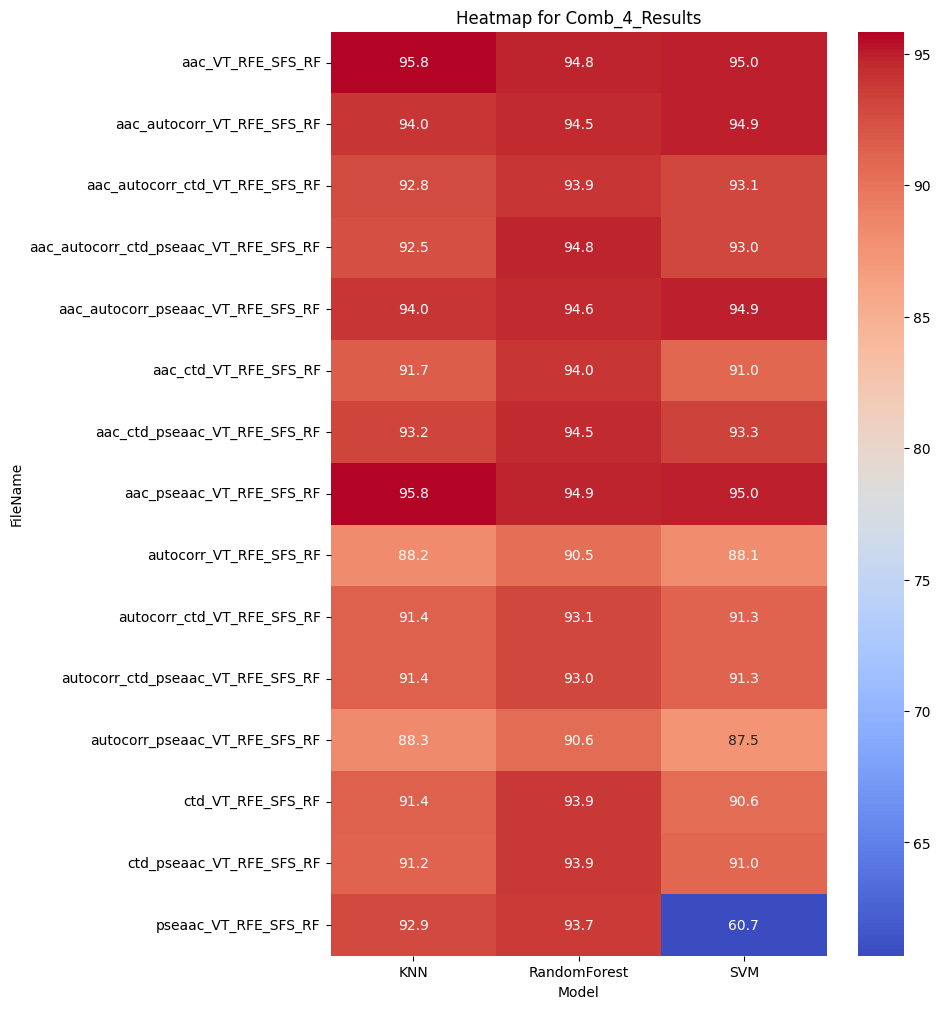

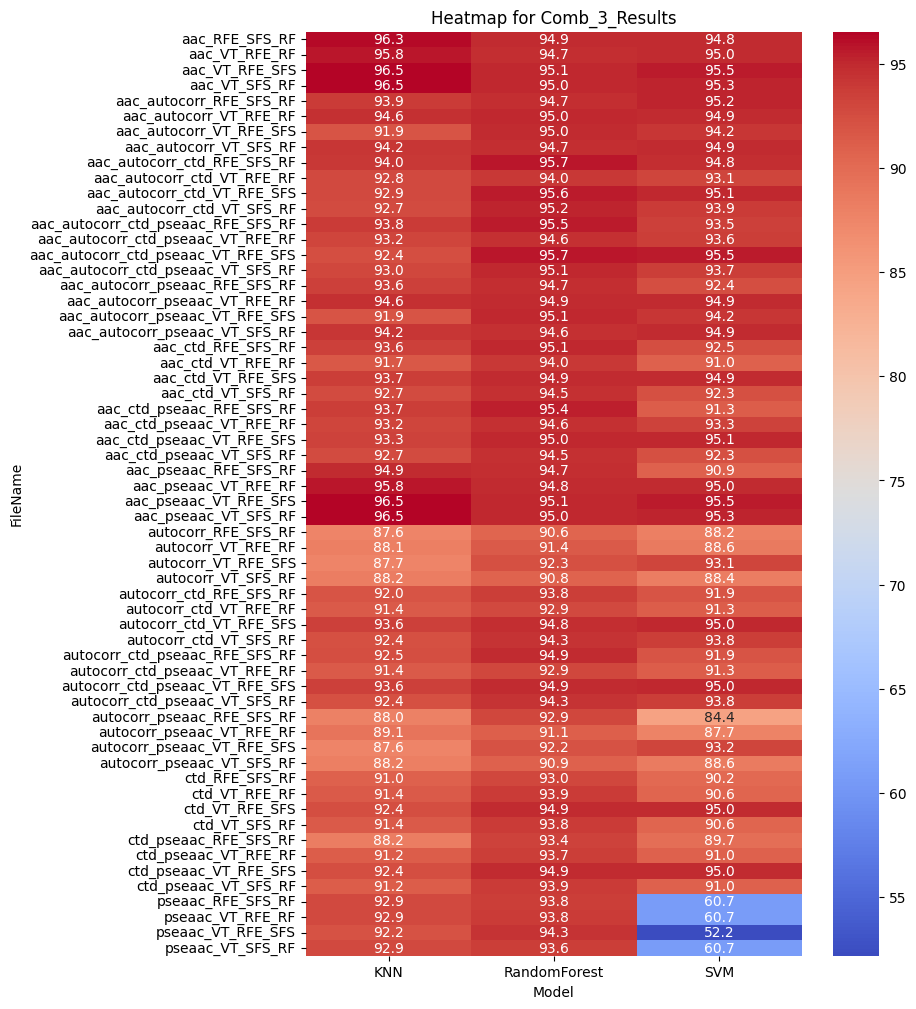

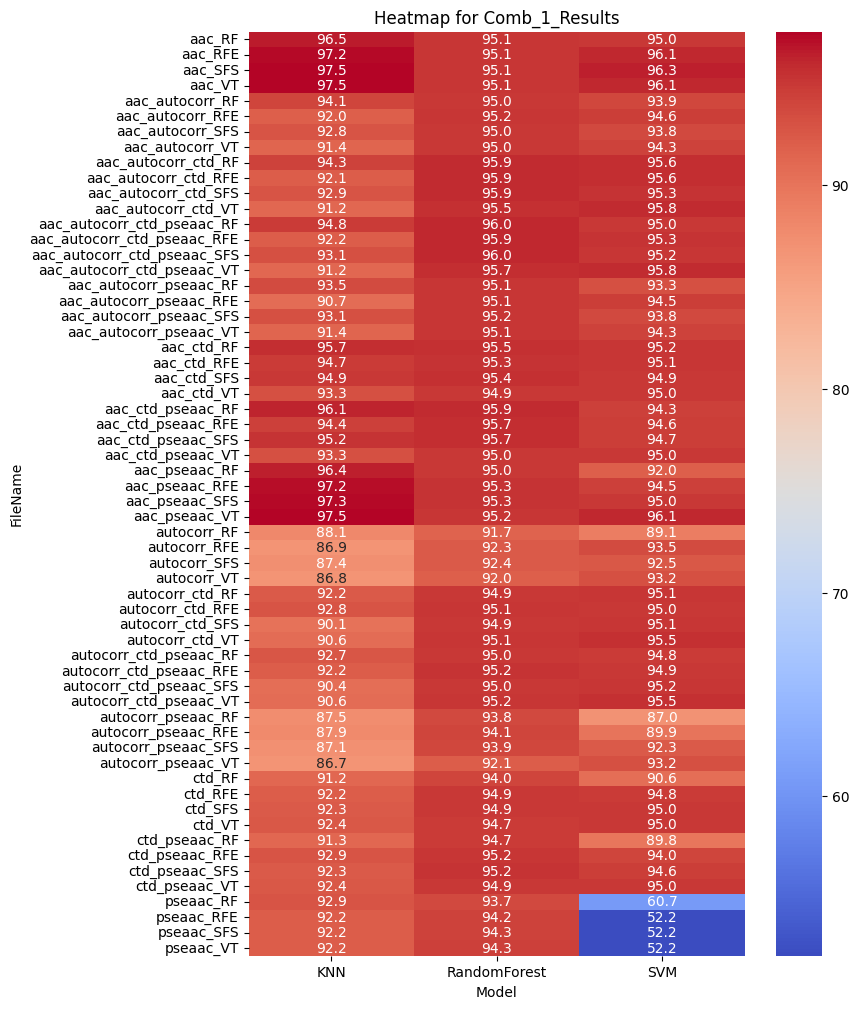

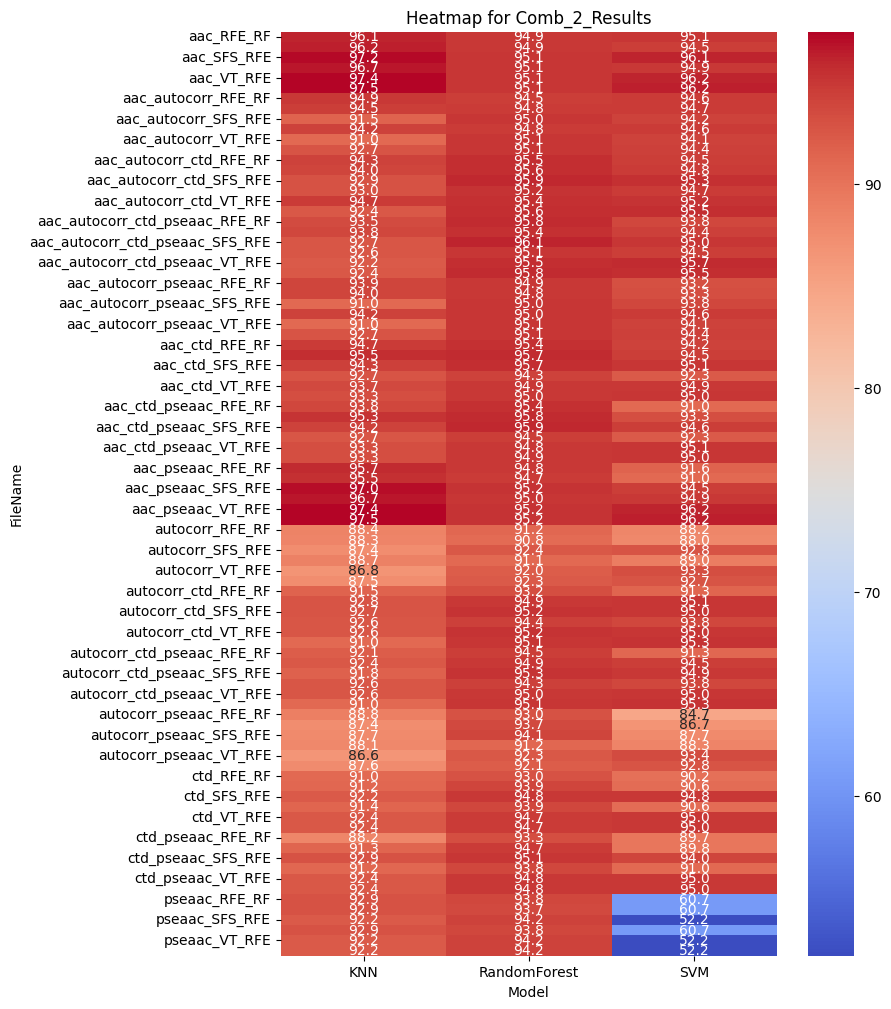

In [ ]:
for file_name in os.listdir('/content/drive/MyDrive/AMPs/Project_outputs/Models_Evalution '):
    if file_name.endswith(".csv"):
        file_path = os.path.join('/content/drive/MyDrive/AMPs/Project_outputs/Models_Evalution ', file_name)
        # Example DataFrame
        df = pd.read_csv(file_path)

        # Remove '_selected_features.csv' from 'FileName' column
        df['FileName'] = df['FileName'].str.replace('_selected_features.csv', '', regex=False)

        # Pivot table to reshape the DataFrame
        heatmap_data = df.pivot(index="FileName", columns="Model", values="ACC")

        # Plot heatmap using Seaborn
        plt.figure(figsize=(8, 12))
        sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm")
        plt.title("Heatmap for "+ file_name.split('.')[0])
        plt.savefig('/content/drive/MyDrive/AMPs/Project_outputs/Heat Maps/'+file_name.split('.')[0]+'.png', bbox_inches='tight')
        plt.show()


In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Loop through each CSV file
for file_name in os.listdir('/content/drive/MyDrive/AMPs/Project_outputs/Models_Evalution '):
    if file_name.endswith(".csv"):
        file_path = os.path.join('/content/drive/MyDrive/AMPs/Project_outputs/Models_Evalution ', file_name)
        df = pd.read_csv(file_path)

        # Add a column for the source file
        df['SourceFile'] = file_name

        # Append to the aggregated DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)

# Remove '_selected_features.csv' from 'FileName' column
all_data['FileName'] = all_data['FileName'].str.replace('_selected_features.csv', '', regex=False)

# Group by Model and select top 10 ACC for each model
top_10_by_model = all_data.groupby("Model").apply(lambda x: x.nlargest(3, "ACC")).reset_index(drop=True)



<ipython-input-25-f1ad089e8e23>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_by_model = all_data.groupby("Model").apply(lambda x: x.nlargest(3, "ACC")).reset_index(drop=True)


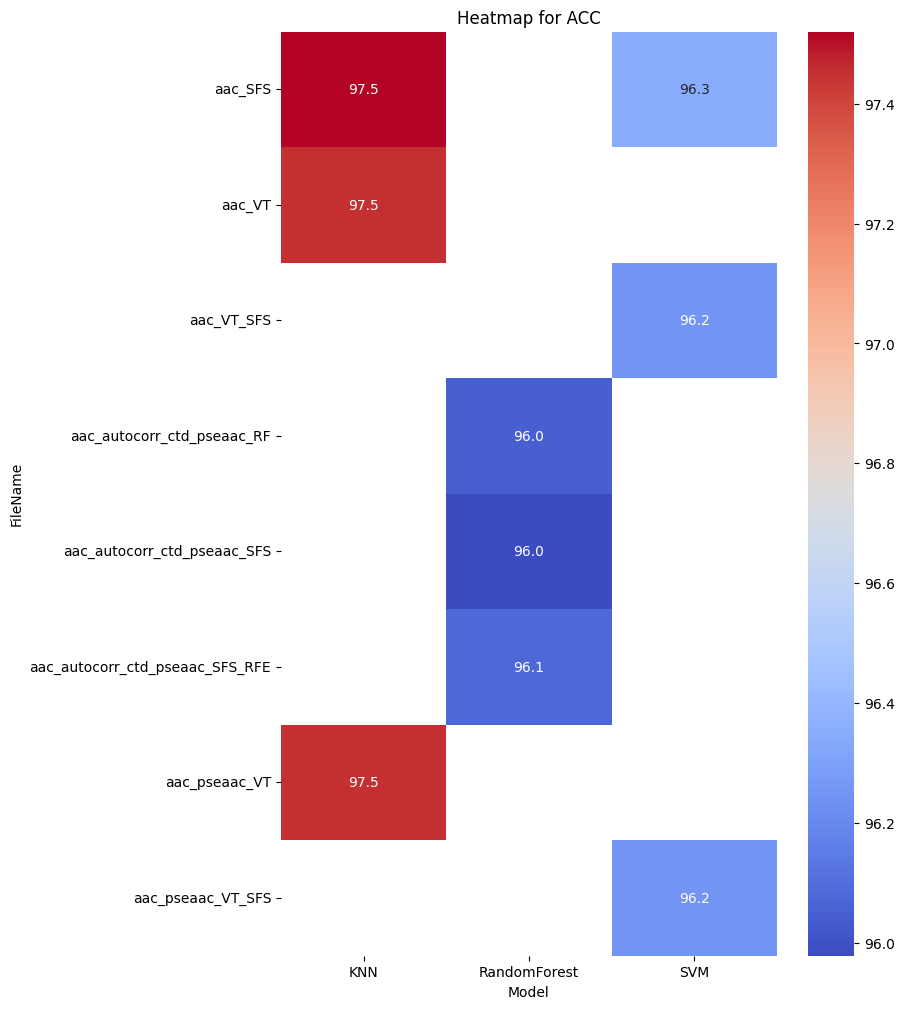

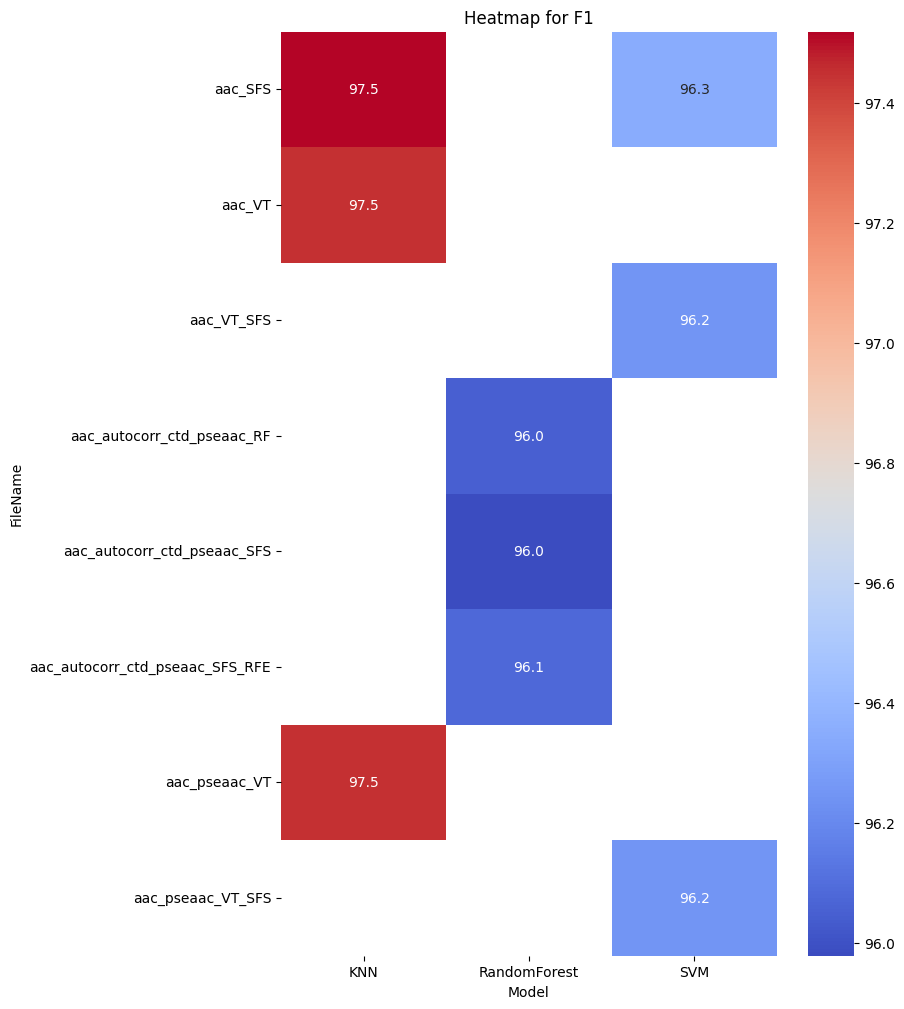

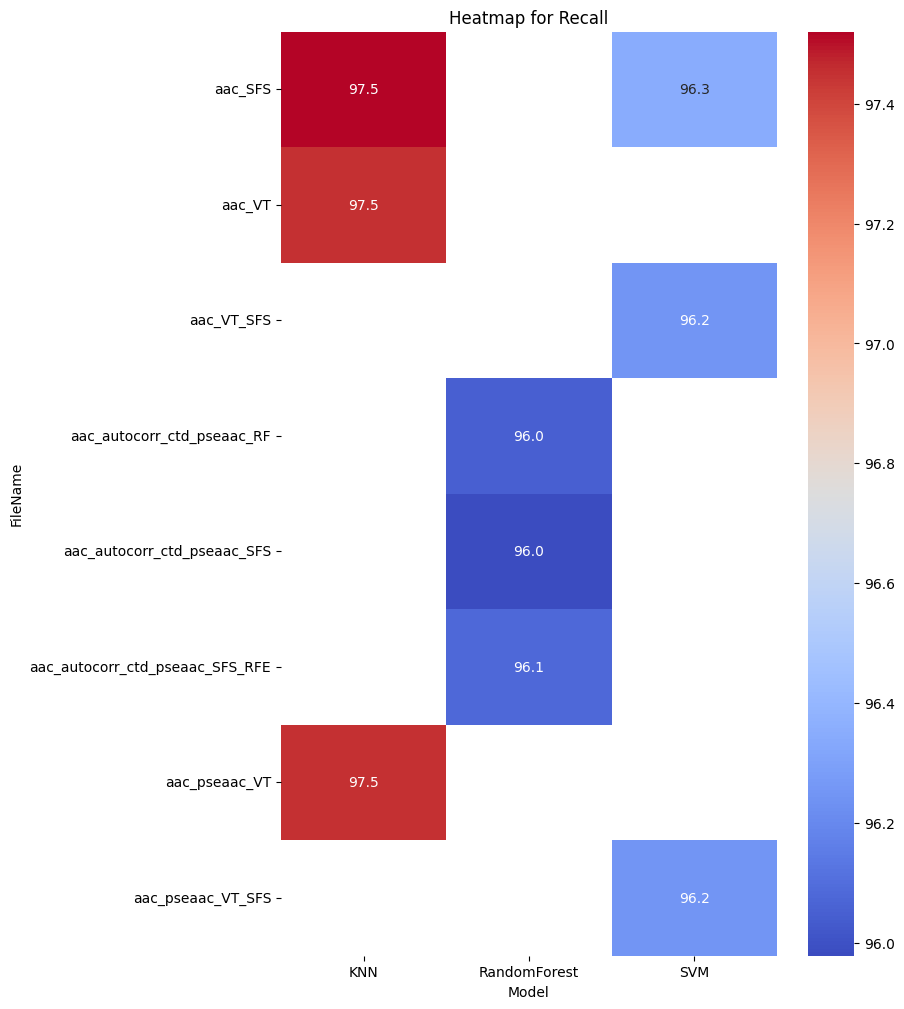

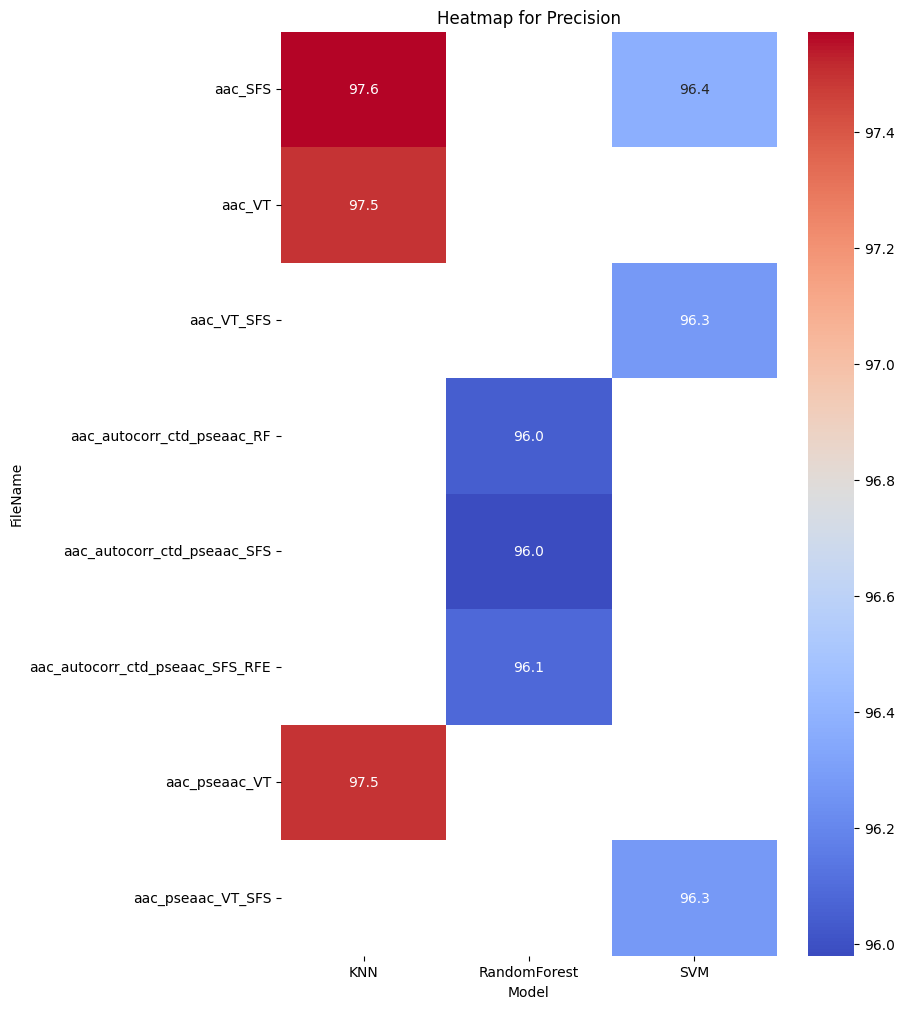

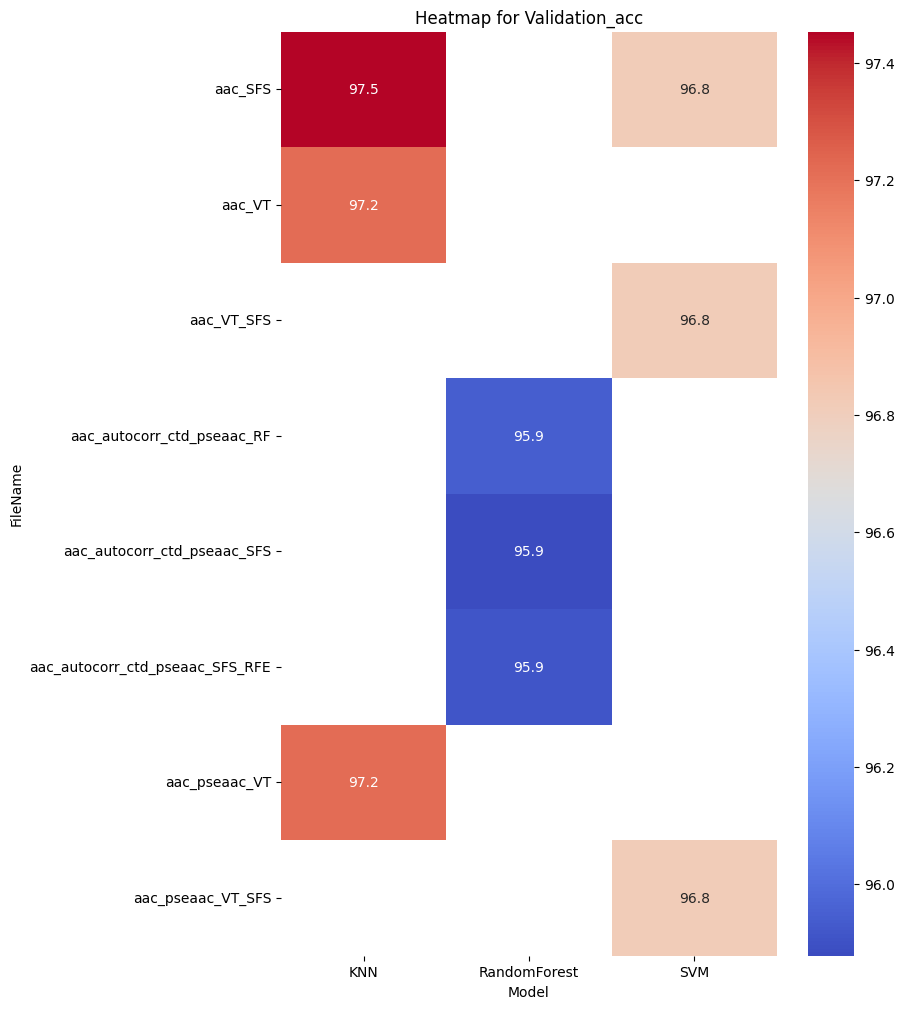

In [ ]:
params = ['ACC', 'F1', 'Recall', 'Precision', 'Validation_acc']
for param in params:
  # Pivot table to reshape the DataFrame
  heatmap_data = top_10_by_model.pivot(index="FileName", columns="Model", values=param)

  # Plot heatmap using Seaborn
  plt.figure(figsize=(8, 12))
  sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm")
  plt.title("Heatmap for "+ param)
  plt.savefig('/content/drive/MyDrive/AMPs/Project_outputs/Heat Maps/'+param+'.png', bbox_inches='tight')
  plt.show()

# features class count

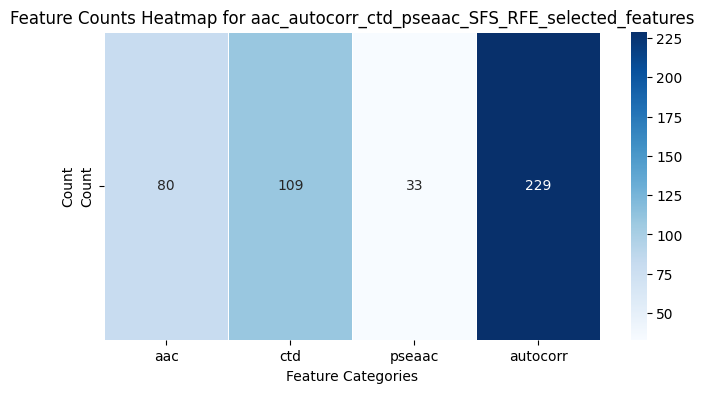

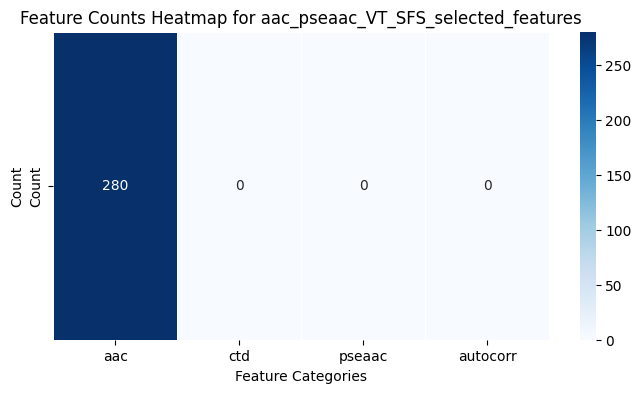

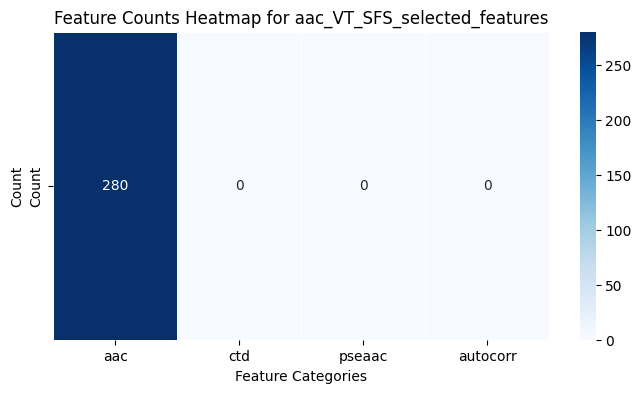

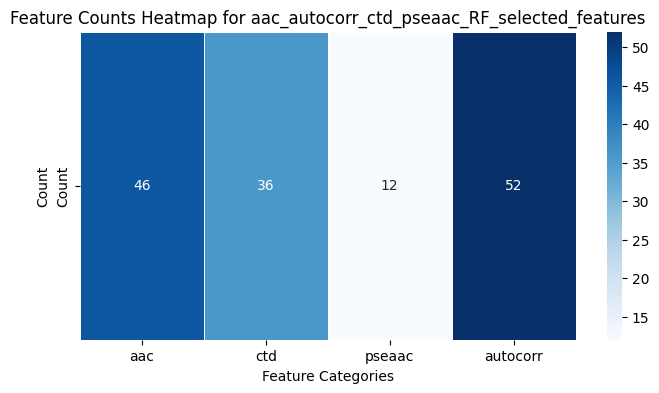

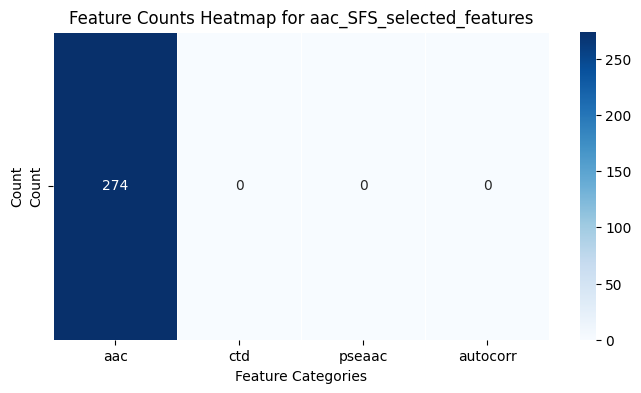

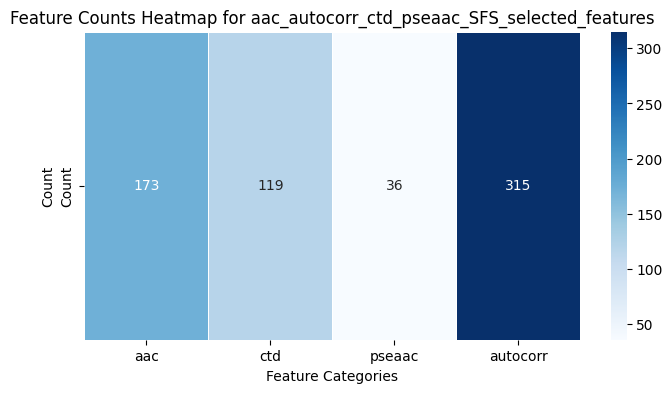

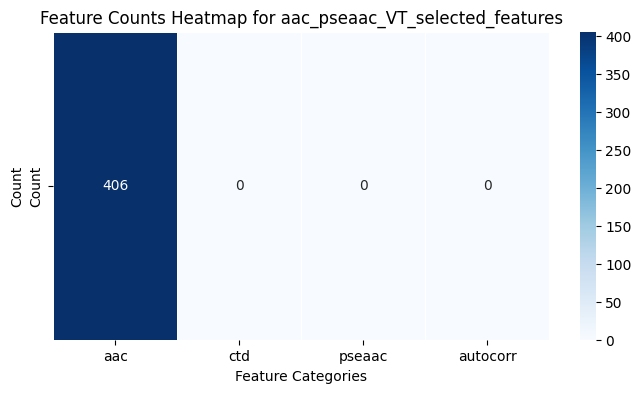

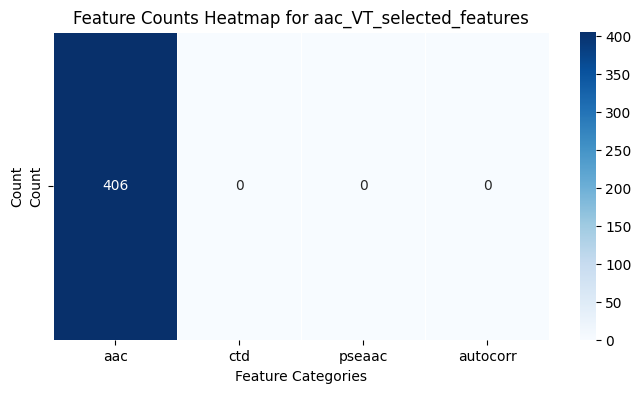

In [ ]:
base_directory = '/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files'

# List to store file paths
file_paths = []

# Walk through the directory and subdirectories
for root, dirs, files in os.walk(base_directory):
    for file in files:
        if file.endswith(".csv"):
            if file in list(top_10_by_model['FileName']+'_selected_features.csv'):
              df = pd.read_csv(os.path.join(root, file))
              counts = {"aac": 0, "ctd": 0, "pseaac": 0, "autocorr": 0}

              # Iterate over columns and apply criteria
              for col in df.columns:
                  if len(col) <= 2:
                      counts["aac"] += 1
                  elif col.startswith("_"):
                      counts["ctd"] += 1
                  elif col.startswith("APA"):
                      counts["pseaac"] += 1
                  elif any(col.startswith(prefix) for prefix in ["Moreau", "Moran", "Geary"]):
                      counts["autocorr"] += 1
              df1 = pd.DataFrame(counts, index=["Count"])

              # Create a heatmap with white to blue color map
              plt.figure(figsize=(8, 4))  # Set the size of the heatmap
              sns.heatmap(df1, annot=True, cmap='Blues', fmt='d', linewidths=0.5)

              # Add labels and title
              plt.title('Feature Counts Heatmap for '+file.split('.')[0])
              plt.xlabel('Feature Categories')
              plt.ylabel('Count')
              plt.savefig('/content/drive/MyDrive/AMPs/Project_outputs/Features Distribution /'+file.split('.')[0]+'.png', bbox_inches='tight')
              # Show plot
              plt.show()

# Confusion Matrix

aac_autocorr_ctd_pseaac_SFS_RFE_selected_features.csv
aac_autocorr_ctd_pseaac_SFS_RFE


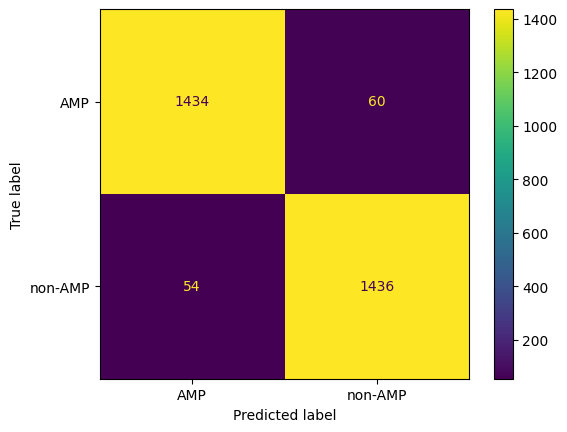

aac_pseaac_VT_SFS_selected_features.csv
aac_pseaac_VT_SFS


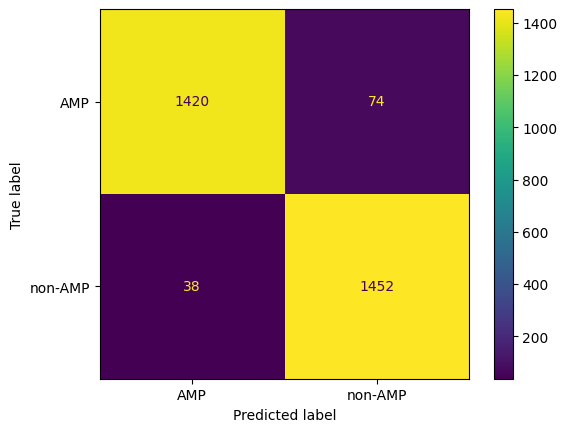

aac_VT_SFS_selected_features.csv
aac_VT_SFS


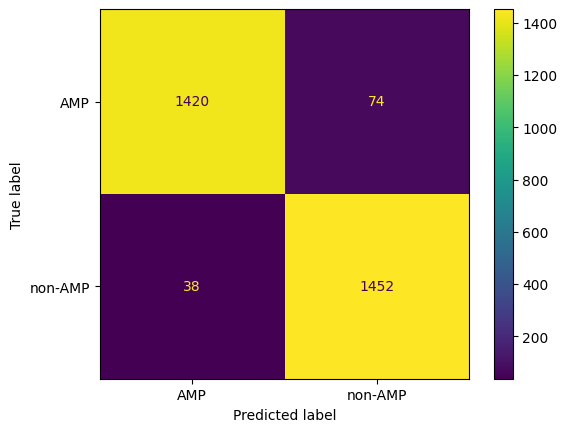

aac_autocorr_ctd_pseaac_RF_selected_features.csv
aac_autocorr_ctd_pseaac_RF


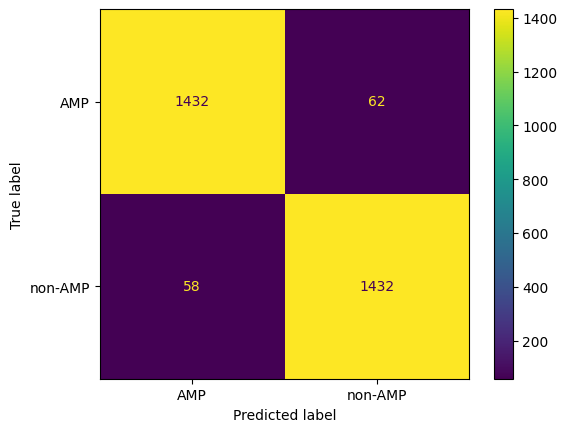

aac_SFS_selected_features.csv
aac_SFS


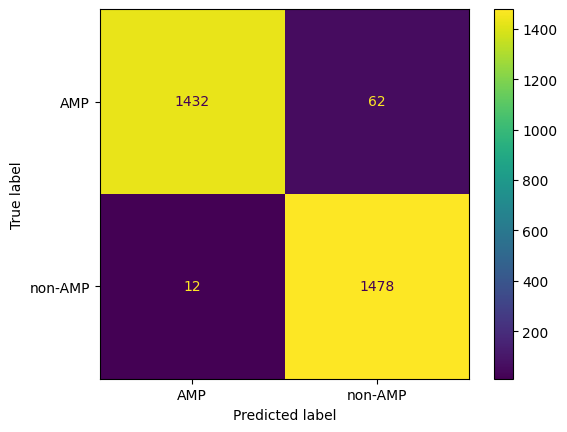

aac_autocorr_ctd_pseaac_SFS_selected_features.csv
aac_autocorr_ctd_pseaac_SFS


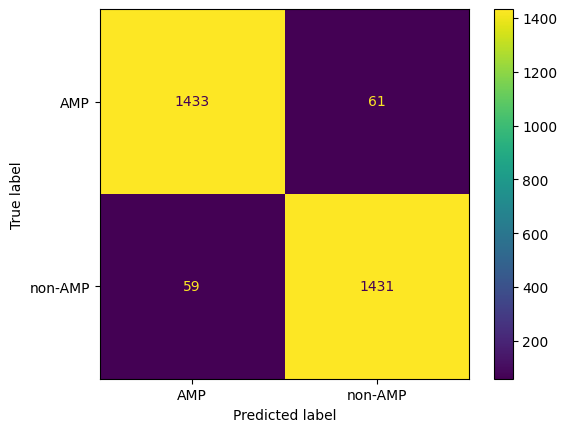

aac_pseaac_VT_selected_features.csv
aac_pseaac_VT


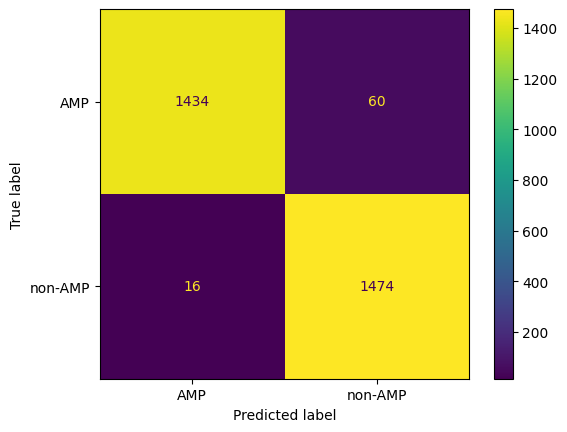

aac_VT_selected_features.csv
aac_VT


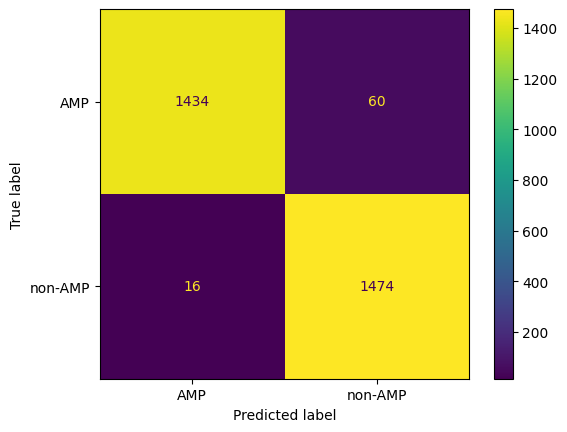

In [ ]:
base_directory = '/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files'
models = {
        "SVM": SVC(kernel= "rbf", C = 100, gamma= "scale"),
        "RandomForest": RandomForestClassifier(max_depth= 40, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1200),
        "KNN": KNeighborsClassifier(metric = "manhattan", weights = "uniform", n_neighbors = 1)
    }
for root, dirs, files in os.walk(base_directory):
    for file in files:
        if file.endswith(".csv"):
            if file in list(top_10_by_model['FileName']+'_selected_features.csv'):
              df = pd.read_csv(os.path.join(root, file))
              X = df.iloc[:,:-1]
              y = df.iloc[:, -1]
              X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train and 4% temp to be divided inot 20 % Test and 20 % valid
              X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% valid, 20% test
              print(file)
              print(file.rstrip('_selected_features.csv'))
              mod = top_10_by_model.loc[top_10_by_model['FileName'] == file.rstrip('_selected_features.csv'), 'Model'].iloc[0]
              model = models[mod]
              model.fit(X_train, y_train)

              y_vali_pred = model.predict(X_val)
              y_vali_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
              y_test_pred = model.predict(X_test)
              y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
              confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
              cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["AMP", "non-AMP"])
              cm_display.plot()
              plt.show()


#XAI-LIME


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb4/aac_VT-RFE-SFS-RF_selected_features.csv")

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

X_train_np = X_train.values
y_train_np = y_train.values

explainer = LimeTabularExplainer(X_train_np, mode='classification',
                                 training_labels=y_train_np, feature_names=X.columns)

idx = 5
sample = X_test.iloc[idx].values
true_label = y_test.iloc[idx]

print("\n--- Sample to Explain ---")
print(f"Sample Index: {idx}")
print(f"Sample Features:")
for feature, value in zip(X.columns, sample):
    print(f"  {feature}: {value}")
print(f"\nTrue Label: {true_label}\n")

explanation = explainer.explain_instance(sample, model.predict_proba, num_features=5)

print("\n--- LIME Explanation ---")
explanation.show_in_notebook()

feature_names_and_importance = explanation.as_list()

print("\n--- Important Features and Their Contributions ---")
print(f"{'Feature Name':<20} | {'Importance'}")
print("-" * 40)
for feature, importance in feature_names_and_importance:
    print(f"{feature:<20} | {importance:.4f}")


# XAI-Shap

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/AMPs/Project Data/Selected_Features Files/Comb1/aac_autocorr_ctd_pseaac_RF_selected_features.csv")

X = df.drop(columns=['Activity'])
y = df['Activity']

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    max_depth=40, max_features='sqrt', min_samples_leaf=1,
    min_samples_split=2, n_estimators=1200, random_state=42
)
model.fit(df_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test)



AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

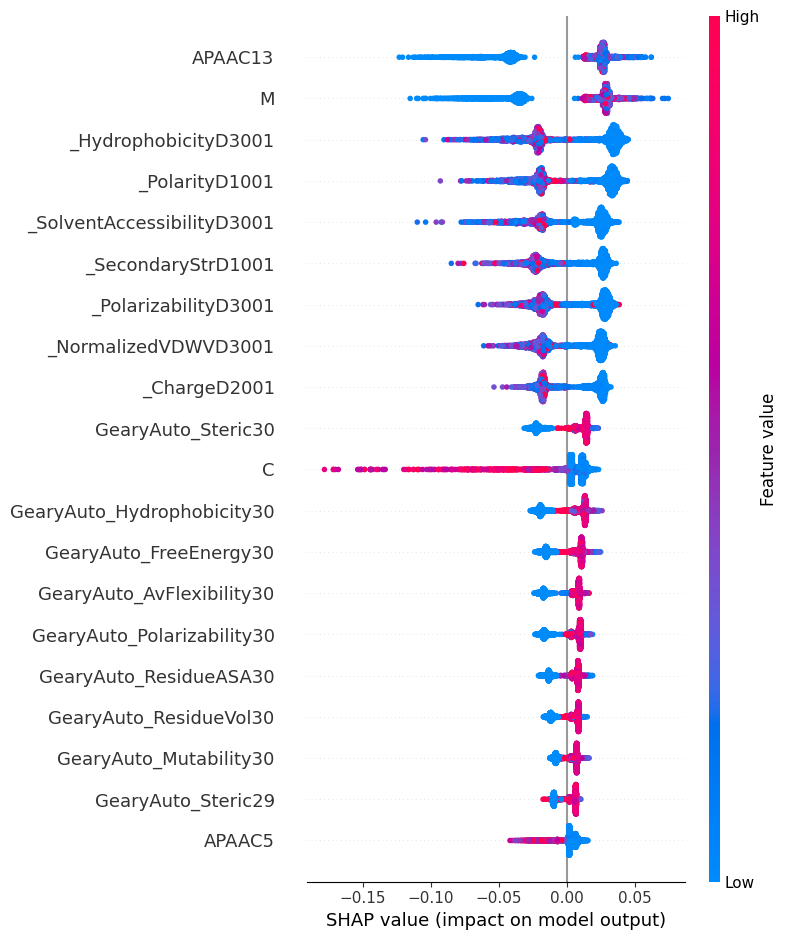

In [ ]:
shap.summary_plot(shap_values[:, :, 1], df_test)


#Save Best 3 combinations

In [ ]:
def parsing(file_name):

    base_name = os.path.splitext(file_name)[0]
    print(base_name)
    found_features = []
    found_fs = []

    if "pseaac" in base_name.split("_"):
        found_features.append("Pseudo AminoAcidComposition")
    if "aac" in base_name.split("_"):
        found_features.append("AminoAcidComposition")
    if "ctd" in base_name.split("_"):
        found_features.append("Composition, Transition, and Distribution.")
    if "autocorr" in base_name.split("_"):
        found_features.append("Autocorrelation")

    if "Boruta" in base_name.split("_"):
        found_fs.append("Boruta")
    if "RF" in base_name.split("_"):
        found_fs.append("Random Forest")
    if "VT" in base_name.split("_"):
        found_fs.append("Variance Threshold")
    if "RFE" in base_name.split("_"):
        found_fs.append("Recursive Feature Elimination")

    features = " & ".join(found_features)
    fs = " & ".join(found_fs)

    print("Features:", features)
    print("Feature Selection Methods:", fs)

    return features, fs

def model_run(path):
    f = os.path.basename(path)
    features, fs = parsing(f)

    data = pd.read_csv(path)
    X = data.iloc[:,:-1]
    y = data.iloc[:, -1]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train and 4% temp to be divided inot 20 % Test and 20 % valid
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% valid, 20% test

    models = {
        "RandomForest": RandomForestClassifier(max_depth= 40, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1200),
    }

    results = []

    for mn, model in models.items():
        model.fit(X_train, y_train)

        y_vali_pred = model.predict(X_val)
        y_vali_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        validation_acc = accuracy_score(y_val, y_vali_pred) * 100
        validation_f1 = f1_score(y_val, y_vali_pred, average="weighted") * 100
        validation_recall = recall_score(y_val, y_vali_pred, average="weighted") * 100
        validation_precision = precision_score(y_val, y_vali_pred, average="weighted") * 100
        validation_auc = roc_auc_score(y_val, y_vali_prob) * 100 if y_vali_prob is not None else "N/A"

        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        acc = accuracy_score(y_test, y_test_pred) * 100
        f1 = f1_score(y_test, y_test_pred, average="weighted") * 100
        recall = recall_score(y_test, y_test_pred, average="weighted") * 100
        precision = precision_score(y_test, y_test_pred, average="weighted") * 100
        auc = roc_auc_score(y_test, y_test_prob) * 100 if y_test_prob is not None else "N/A"

        results.append({
            "FileName": file_name,
            "Model": mn,
            "Features": features,
            "FS": fs,
            "ACC": acc,
            "F1": f1,
            "Recall": recall,
            "Precision": precision,
            "Validation_acc": validation_acc,
            "Validation_F1": validation_f1,
            "Validation_Recall": validation_recall,
            "Validation_Precision": validation_precision,
            "Validation_AUC": validation_auc,
            "AUC": auc
        })

    return results, model